### <center>*BigData methods and tools report*<center>
##### <center>Matys Piotr 260337<center>


### **List 3**

### Importing the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels as sm
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from scipy.signal import welch 

#### Task 1

##### Generating data

In [2]:
data = pd.date_range(start='2021-11-17', end='2022-07-23', freq='6H')
generated = np.cumsum(np.random.normal(0,1, size=data.size))

df = pd.DataFrame(generated, index=data, columns=['kurs'])
df.head()

,kurs
2021-11-17 00:00:00,0.854556
2021-11-17 06:00:00,1.586232
2021-11-17 12:00:00,1.547143
2021-11-17 18:00:00,-0.754017
2021-11-18 00:00:00,-1.880164


##### Data visualization

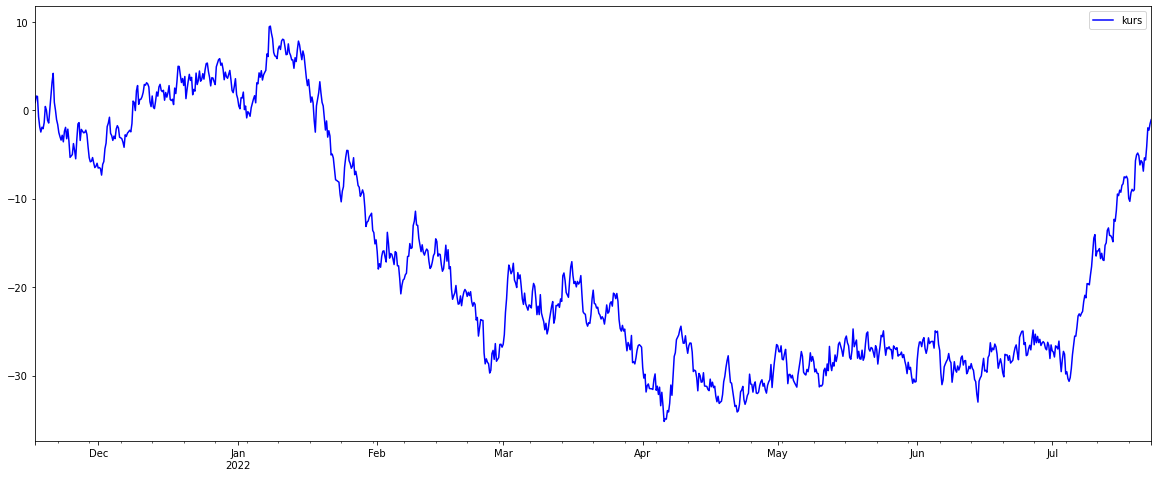

In [3]:
fig, ax = plt.subplots(figsize=(20,8))
df.plot(ax=ax, label='kurs H', color='blue')
plt.show()

##### Checking autocorrelation

[1.         0.994977   0.98997229 0.98504348 0.98045382 0.97643901
 0.97277947 0.96923415 0.96575723 0.962031   0.95815999 0.9542198
 0.95054974 0.94695652 0.94294599 0.93883167 0.93514476 0.93133803
 0.92807969 0.92473364 0.92173025 0.91875479 0.9157507  0.91286367
 0.90957399 0.90620943 0.90272486 0.89897498 0.89520224 0.89131767]


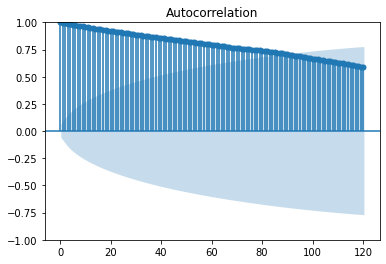

In [4]:
print(acf(df))

plot_acf(df, lags=120)
plt.rc("figure", figsize=(25,6))
plt.show()

##### Exponential smoothing

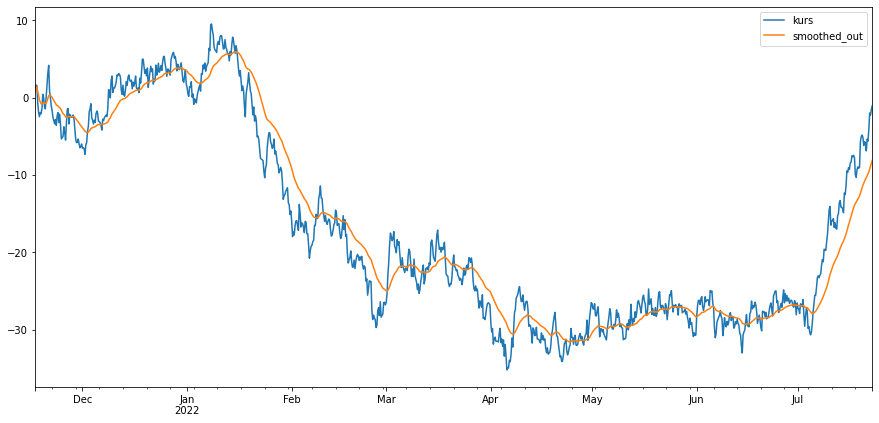

In [5]:
df.insert(1, 'smoothed_out', df['kurs'].ewm(alpha=0.05).mean())
df.plot(figsize=(15, 7))
plt.show()

##### Decomposition of the time series into seasonality, trend and residual

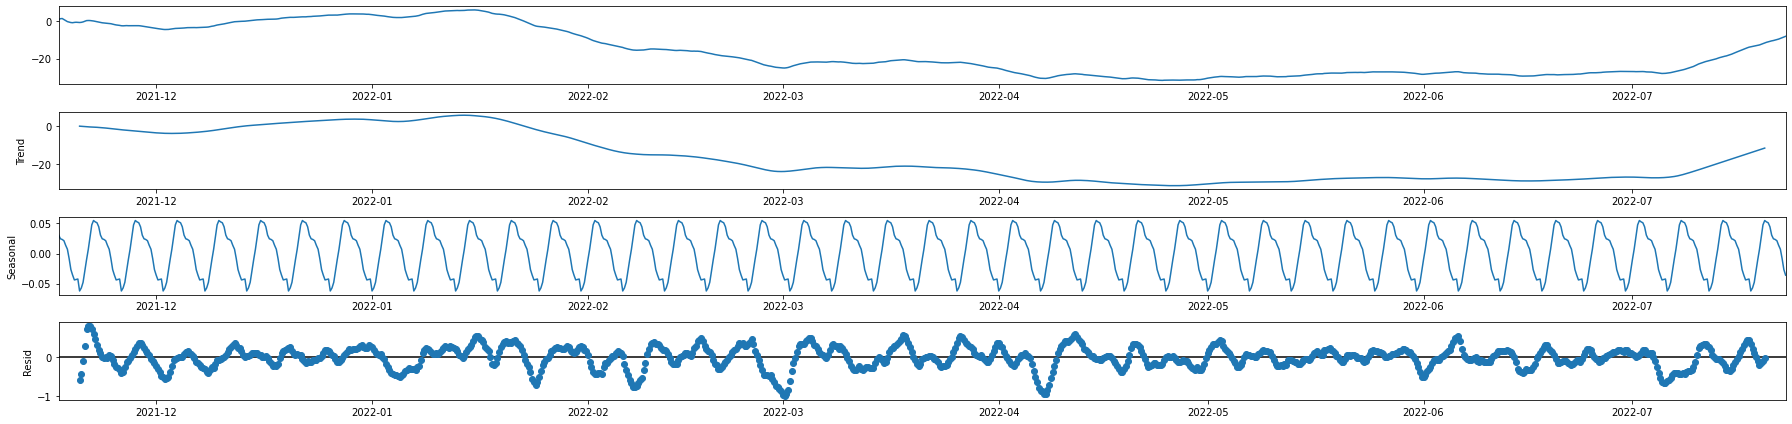

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df[['smoothed_out']], model='additive')

decomposition.plot()
plt.show()

In [7]:
trend, seasonal, resid = pd.DataFrame(decomposition.trend), pd.DataFrame(decomposition.seasonal), pd.DataFrame(decomposition.resid)
resid.isna().head(5)

,resid
2021-11-17 00:00:00,True
2021-11-17 06:00:00,True
2021-11-17 12:00:00,True
2021-11-17 18:00:00,True
2021-11-18 00:00:00,True


In [8]:
seasonal.head(5)

,seasonal
2021-11-17 00:00:00,0.030611
2021-11-17 06:00:00,0.024549
2021-11-17 12:00:00,0.023413
2021-11-17 18:00:00,0.021319
2021-11-18 00:00:00,0.013677


##### Aby zbudować model autokorelacyjny, aby otrzymywać akuratne wyniki, należy modelować szereg stacjonarny - o stałej wariancji w czasie. Stacjonarność szeregu można sprawdzić przeprowadzając test statystyczny adfullera. Przyjmijmy nasz poziom istotności $\alpha = 0.05$

In [9]:
from statsmodels.tsa.stattools import adfuller

adfuller(df['smoothed_out'].values)

(-1.5519164292257128,
 0.50769077479486,
 1,
 991,
 {'1%': -3.4369658620871286,
  '5%': -2.8644609013346485,
  '10%': -2.56832523159495},
 -3009.9533759281244)

##### $P$ $value $ (druga wartość) jest większa niż nasz przyjęty poziom istotności, dlatego mamy twarde dowody, że nie możemy odrzucić hipotezy zerowej, która mówi o tym, że szereg nie jest stacjonarny. W rezultacie należy zastosować różnicowanie szeregu czasowego, aby sprowadzić go do szeregu stacjonarnego.

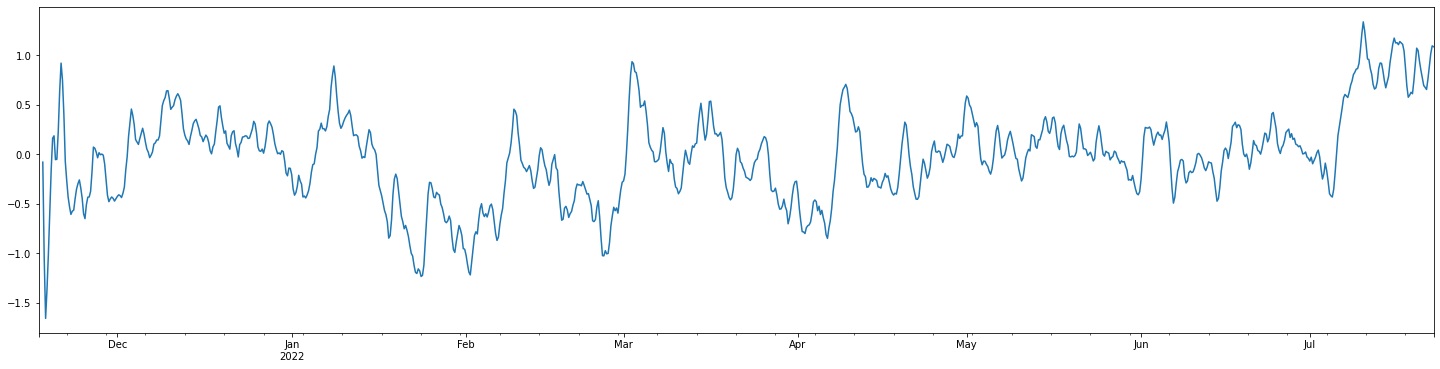

In [10]:
diff = df["smoothed_out"].diff(periods=3)
diff.plot()
plt.show()

In [11]:
diff = diff.dropna()
diff

2021-11-17 18:00:00   -0.078245
2021-11-18 00:00:00   -1.040610
2021-11-18 06:00:00   -1.655295
2021-11-18 12:00:00   -1.359455
2021-11-18 18:00:00   -0.997747
                         ...   
2022-07-22 00:00:00    0.762346
2022-07-22 06:00:00    0.893949
2022-07-22 12:00:00    1.017997
2022-07-22 18:00:00    1.096285
2022-07-23 00:00:00    1.087595
Freq: 6H, Name: smoothed_out, Length: 990, dtype: float64

##### Autocorrelation after differencing 

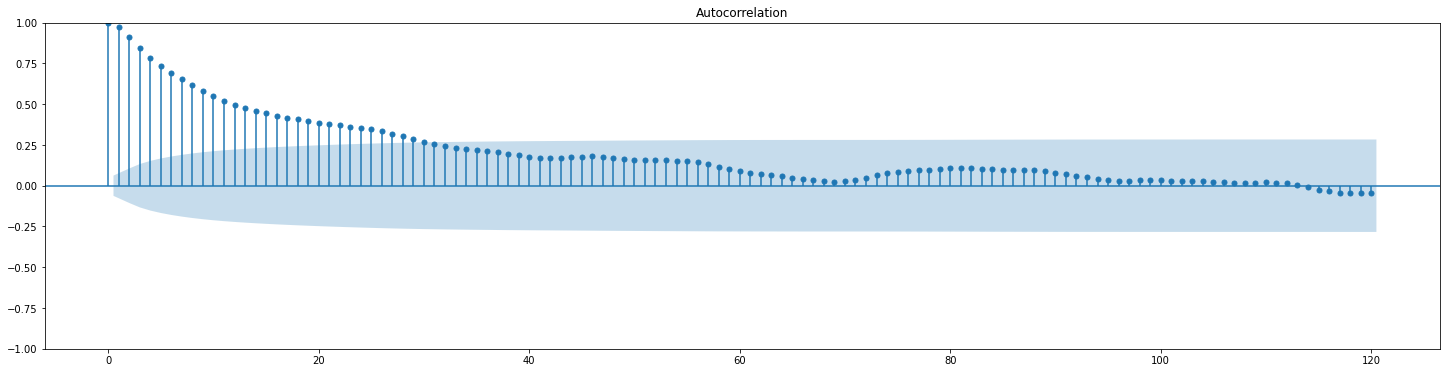

In [12]:
plt.rc("figure", figsize=(25,6))
fig = plot_acf(diff, lags=120)
plt.show()

##### Autocorrelation before  and after differencing

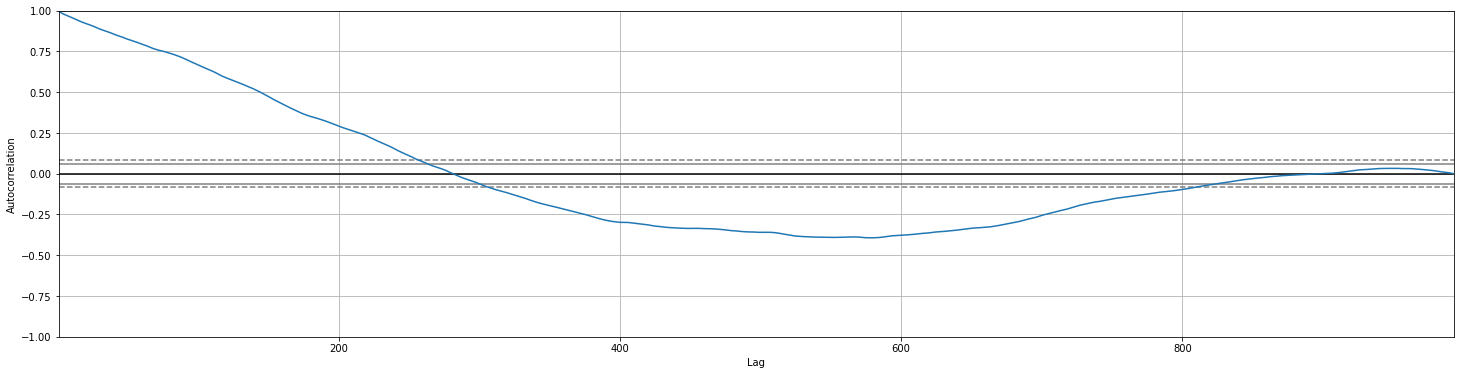

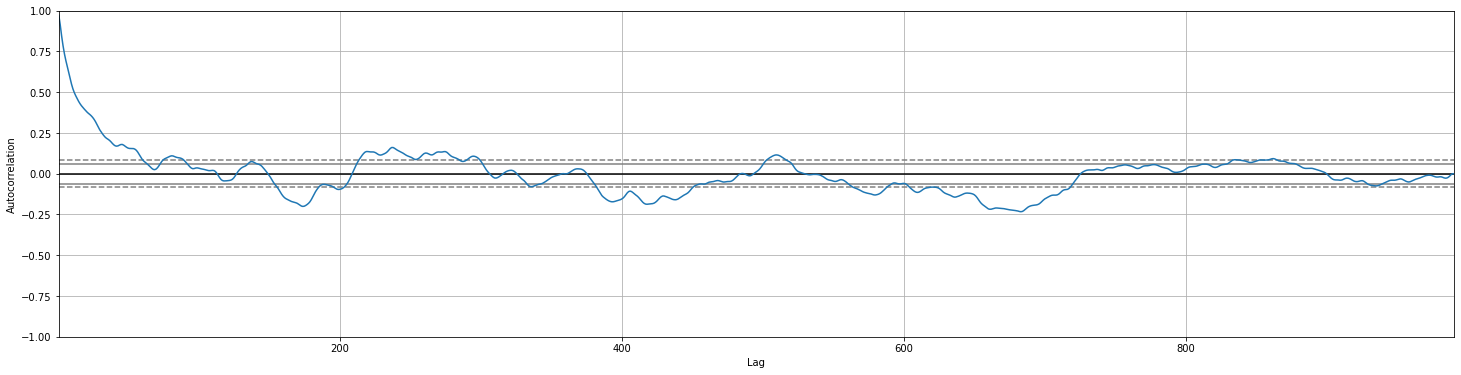

In [13]:
from pandas.plotting import autocorrelation_plot

fig = autocorrelation_plot(df["kurs"])
plt.show()
fig = autocorrelation_plot(diff)
plt.show()

##### Spectral density

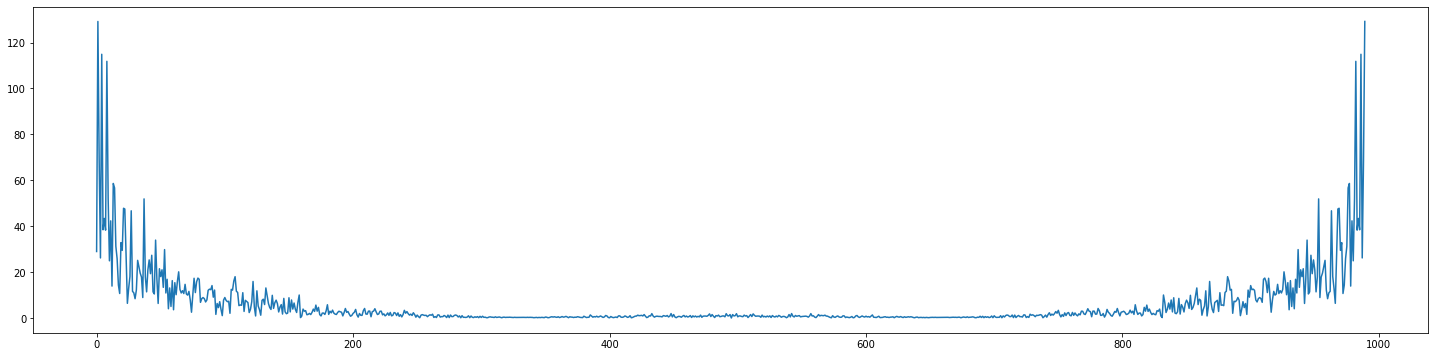

In [16]:
t = np.fft.fft(diff)
plt.plot(np.abs(t))
plt.show()

##### Model AR for time series after differencing

In [18]:
from statsmodels.tsa.ar_model import AutoReg

train_data = diff[:int(len(df) * 0.8) + 1]
test_data = diff[int(len(df) * 0.8) + 1:]

model_AR = AutoReg(train_data, lags=200)
res = model_AR.fit()

##### Model AR for residual

In [30]:
resid = resid.dropna()

train_data_resid = resid['resid'][:int(len(resid) * 0.8) + 1]
test_data_resid = resid['resid'][int(len(resid) * 0.8):]

model_AR_resid = AutoReg(train_data_resid, lags=200)
res_resid = model_AR_resid.fit()

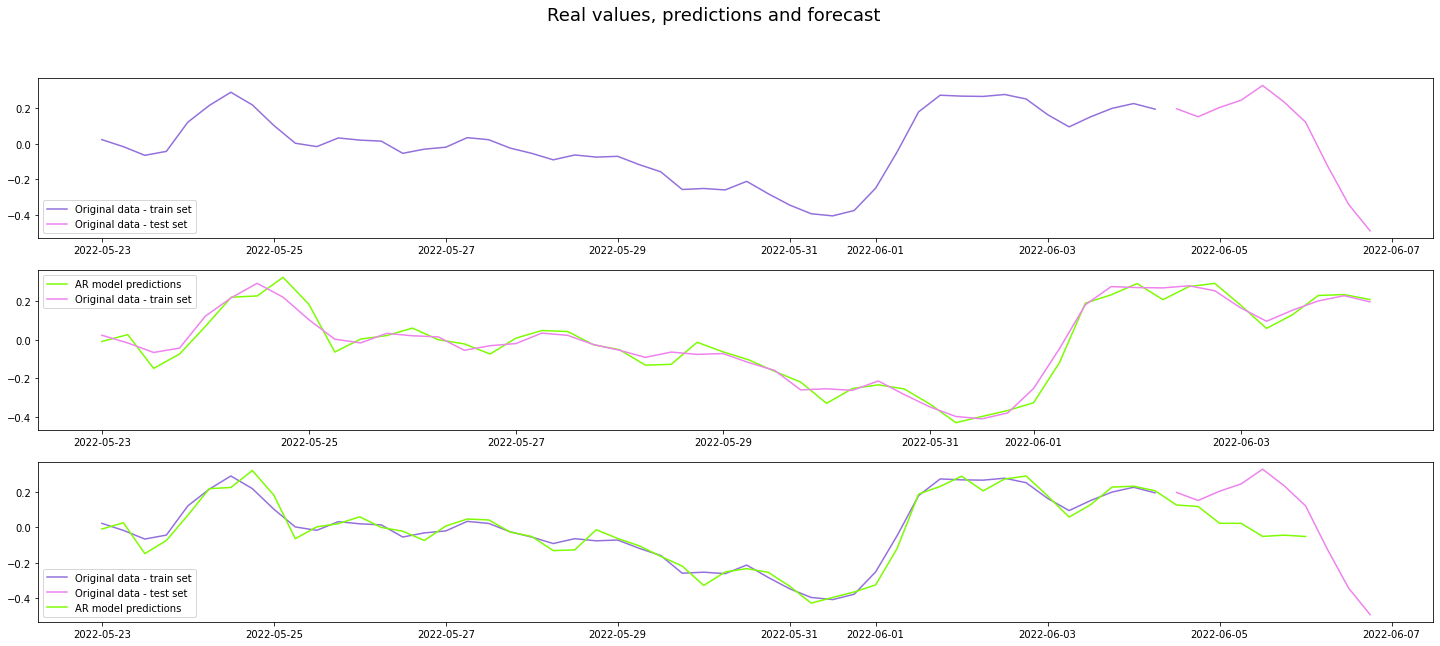

In [31]:
predictions = res.predict(start=train_data.index[-50], end=test_data.index[6])

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(25, 10))
fig.suptitle('Real values, predictions and forecast', fontsize=18)

ax1.plot(train_data[-50:], color = '#9370DB', label="Original data - train set")
ax1.plot(test_data[:10], color = '#EE82EE', label="Original data - test set")
ax1.legend()

ax2.plot(predictions[:50], color = '#7CFC00', label="AR model predictions")
ax2.plot(train_data[-50:], color = '#EE82EE', label="Original data - train set")
ax2.legend()

ax3.plot(train_data[-50:], color = '#9370DB', label="Original data - train set")
ax3.plot(test_data[:10], color = '#EE82EE', label="Original data - test set")
ax3.plot(predictions, color = '#7CFC00', label="AR model predictions")
ax3.legend()

plt.show()

In [22]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(train_data[-10:], predictions))
print(f'Root mean squarred error: {rmse}')

Root mean squarred error: 0.029269226136583733


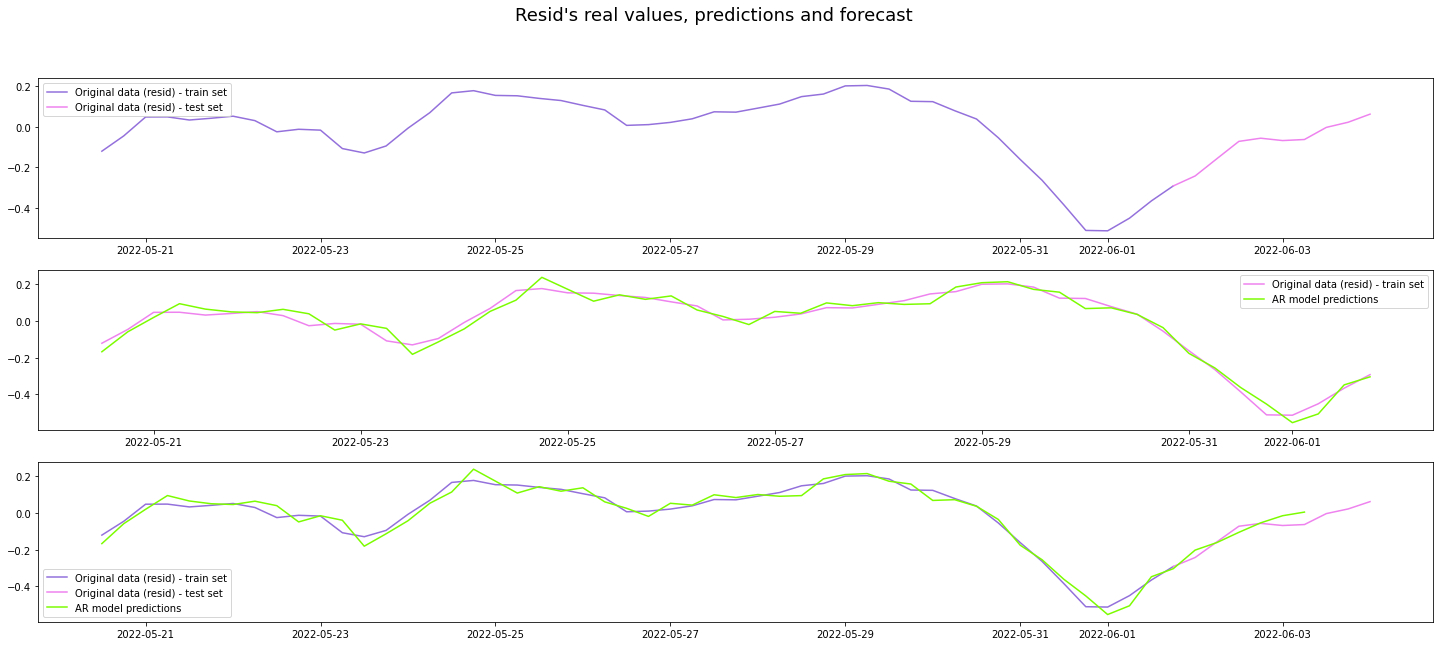

In [37]:
predictions_resid = res_resid.predict(start=train_data_resid.index[-50], end=test_data_resid.index[6])

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(25, 10))
fig.suptitle("Resid's real values, predictions and forecast", fontsize=18)

ax1.plot(train_data_resid[-50:], color = '#9370DB', label="Original data (resid) - train set")
ax1.plot(test_data_resid[:10], color = '#EE82EE', label="Original data (resid) - test set")
ax1.legend()

ax2.plot(train_data_resid[-50:], color = '#EE82EE', label="Original data (resid) - train set")
ax2.plot(predictions_resid[:50], color = '#7CFC00', label="AR model predictions")
ax2.legend()

ax3.plot(train_data_resid[-50:], color = '#9370DB', label="Original data (resid) - train set")
ax3.plot(test_data_resid[:10], color = '#EE82EE', label="Original data (resid) - test set")
ax3.plot(predictions_resid, color = '#7CFC00', label="AR model predictions")
ax3.legend()

plt.show()

##### In both cases the predictions for AR models are very close to the real values, having sometimes higher values, sometimes lower. However, in the case of forecasting subsequent values, after 2 forecasted values, the values begin to oscillate around the mean and are different from the actual values

##### Task 2

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels as sm
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from datetime import datetime, timedelta

##### Creating model with part MA without AR part does not make a big sense due to the fact that the purpose of this model is to predict errors between real values and predictions but we actually dont know what these predictions errors are.

##### Let's suppose we know our MA model - its equation looks like this:
$ y_t = 50 + 0.4\varepsilon_{t-1} + 0.3\varepsilon_{t-2} + \varepsilon_t\newline$
$\varepsilon_t \sim N(0,1)$

In [40]:
np.random.seed(420)

mu = 50
series = []

errors = np.random.normal(0, 1, 400)
date_index = pd.date_range(start='2021-11-17', end='2022-07-23')

for t in range(1, len(date_index) + 1):
    series.append(mu + 0.4*errors[t - 1] + 0.3*errors[t - 2] + errors[t])

In [41]:
generated_data = pd.Series(series, date_index)
generated_data.head(5)

2021-11-17    47.799139
2021-11-18    48.566099
2021-11-19    48.904419
2021-11-20    50.047422
2021-11-21    50.976756
Freq: D, dtype: float64

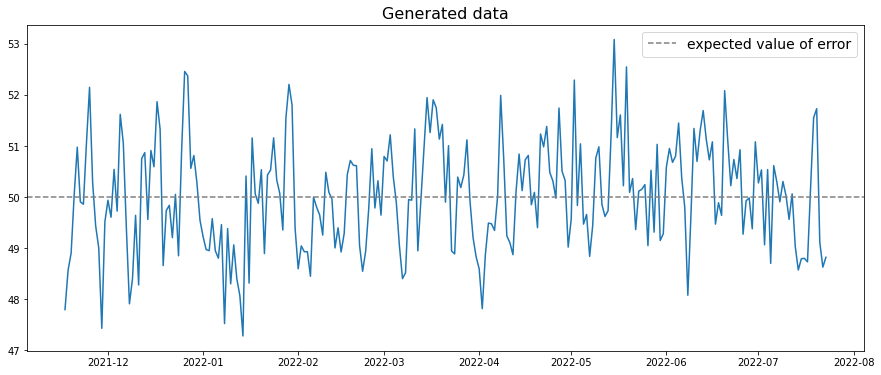

In [42]:
plt.figure(figsize=(15,6))
plt.title('Generated data', fontsize=16)
plt.plot(generated_data)
plt.axhline(mu, linestyle='--', color='grey', label='expected value of error')
plt.legend(fontsize=14)
plt.show()

##### We would like to concentrate on MA, so when we create model we will only need to choose appriopriate q value which is the order of the MA term (q). To do this let's look at ACF plot.

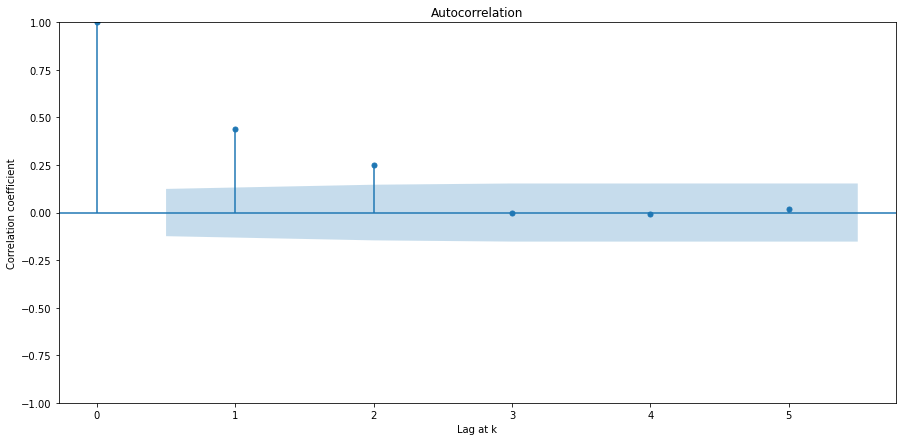

In [43]:
fig = plot_acf(generated_data, lags=5)
fig.set_size_inches((15, 7))
plt.xlabel("Lag at k")
plt.ylabel("Correlation coefficient")
plt.show()

##### We perform this procedure in order to remove any autocorrelation in the series.

##### We are looking for the first lag which value is sligthly above confidence interval - in this case the most appriopriate number of lags seems to be 2.

##### Tworzenie modelu

In [99]:
from statsmodels.tsa.arima.model import ARIMA

train_end_artificial_data = datetime(2022, 7, 21)
test_end_artificial_data = datetime(2022, 7, 23)

train_set_artificial_data = generated_data[:train_end_artificial_data + timedelta(days=1)]
test_set_artificial_data = generated_data[train_end_artificial_data + timedelta(days=1):test_end_artificial_data]

ARMA_model = ARIMA(train_set_artificial_data, order=(0, 0, 2)) # the third value corresponds to number of lags
results_ad = ARMA_model.fit()

##### When we look into our model's equation, we can see that it is able to predict 3 values forward, after that our model will start generate values which will be equal to mean - that is the reason why test set is so small.

In [100]:
print(results_ad.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  248
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -332.813
Date:                Tue, 10 May 2022   AIC                            673.626
Time:                        19:36:37   BIC                            687.680
Sample:                    11-17-2021   HQIC                           679.283
                         - 07-22-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.0148      0.106    471.615      0.000      49.807      50.223
ma.L1          0.4318      0.061      7.104      0.000       0.313       0.551
ma.L2          0.3743      0.069      5.425      0.0

##### The most important information is displayed in the second row - values of coefficients and their statistical significance. Let's assume significance level is $\alpha$ = 0.05. In the column entitled P > |z| we can see that all values are 0 - it means that all coefficients are statistically significant.

##### Equation of created model:
$ y_t = 50 + 0.42\varepsilon_{t-1} + 0.37\varepsilon_{t-2} + \varepsilon_t\newline$
##### It is very similar to our beginning equation

##### Predictions - I suppose I will need this plotting many times, so it is good aproach to write a function.

In [101]:
def plotting_predictions(predictions, train_set, test_set, setting_dict={'nosfts' : 15, 'model' : 'MA', 'y_lim' : None}):

    number_of_samples_from_train_set, model_type, y_lim = setting_dict['nosfts'], setting_dict['model'], setting_dict['y_lim']
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 10))
    fig.suptitle(f'{model_type} model', fontsize=20)

    ax1.plot(train_set[-number_of_samples_from_train_set:], color = '#9370DB', label="Original data - train set")
    ax1.plot(test_set, color = '#EE82EE', label="Original data - test set")
    ax1.legend()

    ax2.plot(predictions, color = '#7CFC00', label="MA model predictions")
    ax2.plot(train_set[-number_of_samples_from_train_set:], color = '#9370DB', label="Original data - train set")
    if y_lim:
        ax2.set_ylim(y_lim)
    ax2.legend()

    ax3.plot(train_set[-number_of_samples_from_train_set:], color = '#9370DB', label="Original data - train set")
    ax3.plot(test_set, color = '#EE82EE', label="Original data - test set")
    ax3.plot(predictions, color = '#7CFC00', label=f"{model_type} model predictions")
    ax3.legend()

    plt.show()

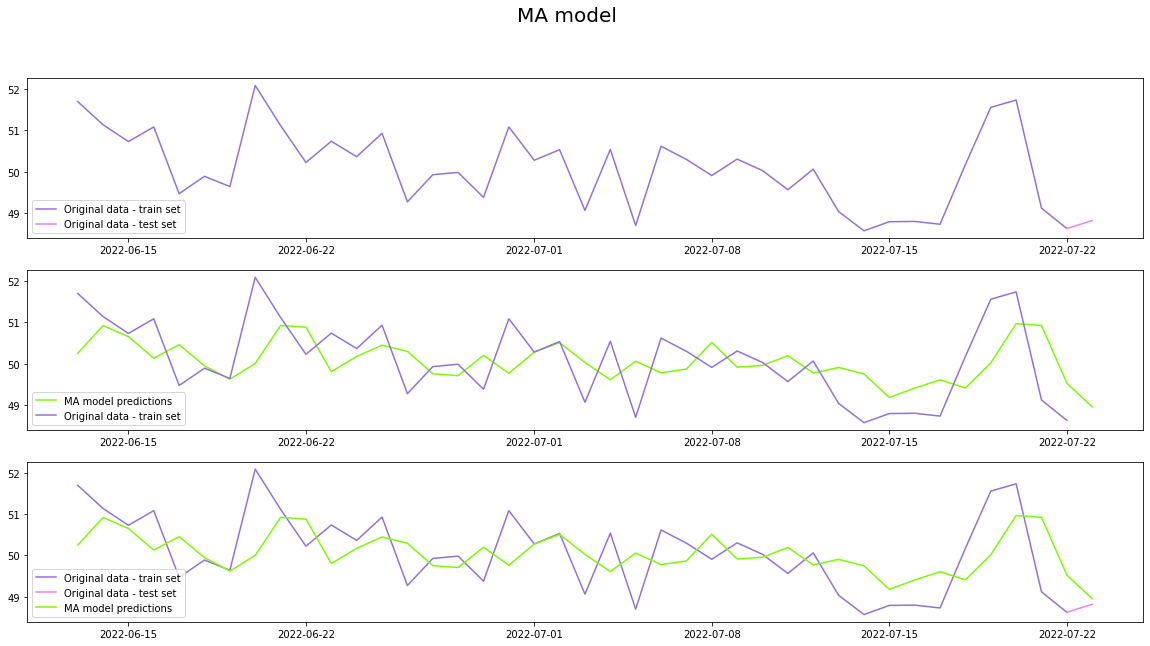

In [103]:
predictions_ad = results_ad.predict(start=train_set_artificial_data.index[-40], end=test_set_artificial_data.index[1])
plotting_predictions(predictions_ad, train_set_artificial_data, test_set_artificial_data, setting_dict={'nosfts' : 40, 'model' : 'MA', 'y_lim' : None})

##### The predicted values deviate from the actual values - they oscillate mainly around the average

In [85]:
residuals = test_set - predictions
print(f'Mean Absolute Percent Error: {round(np.mean(abs(residuals/test_set)), 4)}')
print(f'Root Mean Squared Error:', round(np.sqrt(np.mean(residuals**2)), 4))

Mean Absolute Percent Error: 0.0028
Root Mean Squared Error: 0.0468


##### Now let's switch to real data - we will use data set of changing climate in Delhi between 2013 and 2016 year.

In [86]:
file_name = 'DailyDelhiClimateTrain.csv'
climate_df = pd.read_csv(file_name, index_col=0, parse_dates=True)
climate_df.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


##### We will focus on mean temperature

In [87]:
temp_df = climate_df.drop(['humidity', 'wind_speed', 'meanpressure'], axis=1)
temp_df.head(5)

,meantemp
date,
2013-01-01,10.000000
2013-01-02,7.400000
2013-01-03,7.166667
2013-01-04,8.666667
2013-01-05,6.000000


<AxesSubplot:xlabel='date'>

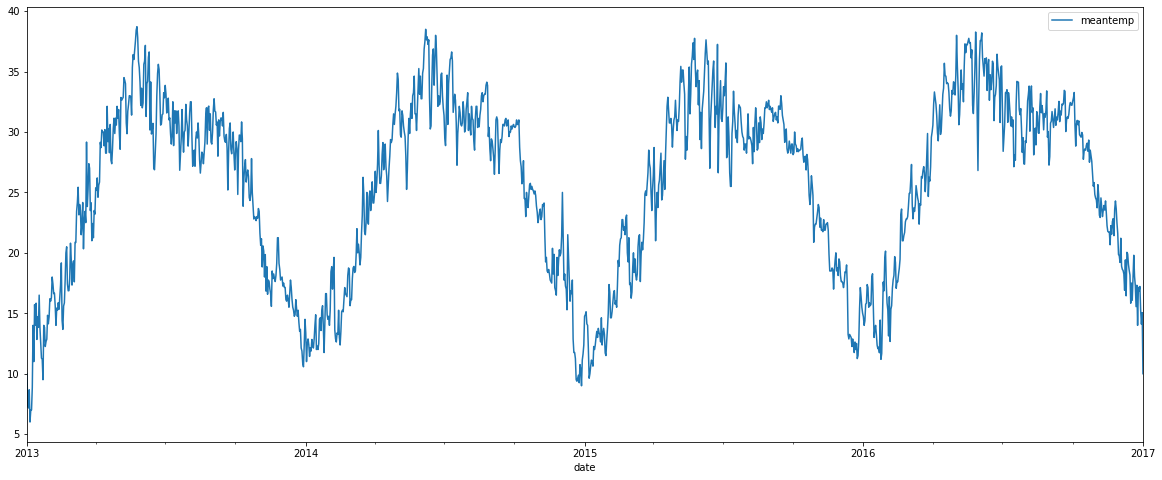

In [88]:
temp_df.plot(figsize=(20, 8))

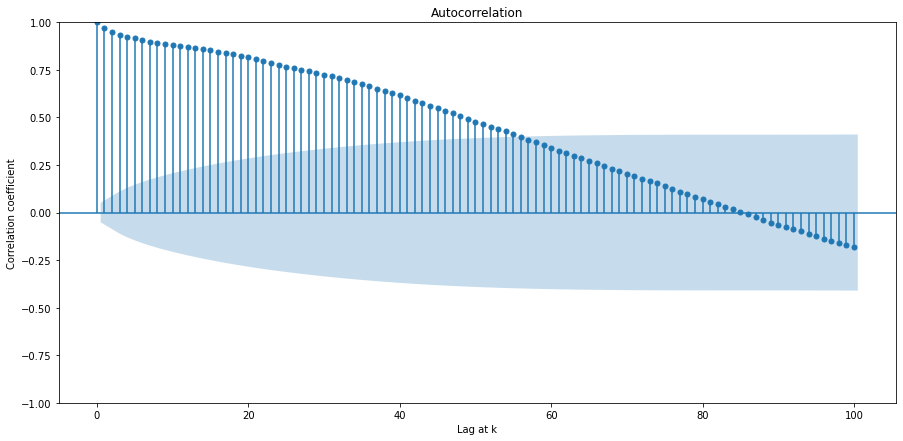

In [89]:
fig = plot_acf(temp_df, lags=100)
fig.set_size_inches((15, 7))
plt.xlabel("Lag at k")
plt.ylabel("Correlation coefficient")
plt.show()

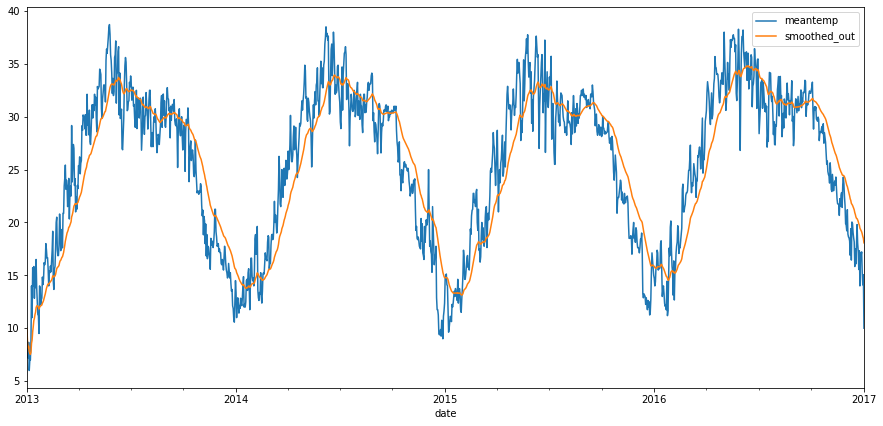

In [90]:
temp_df.insert(1, 'smoothed_out', temp_df['meantemp'].ewm(alpha=0.05).mean())
temp_df.plot(figsize=(15, 7))
plt.show()

In [91]:
from statsmodels.tsa.stattools import adfuller

p_value = adfuller(temp_df['smoothed_out'].values)[1]

print(f' p value : {p_value.round(5)} < 0.05, so we reject hypothesis that time series is not stationary.')

 p value : 0.00062 < 0.05, so we reject hypothesis that time series is not stationary.


##### We do not need to perform differencing - our time series is already stationary. Although we are building MA model, having stationary time series is helpful to create more accurate model.

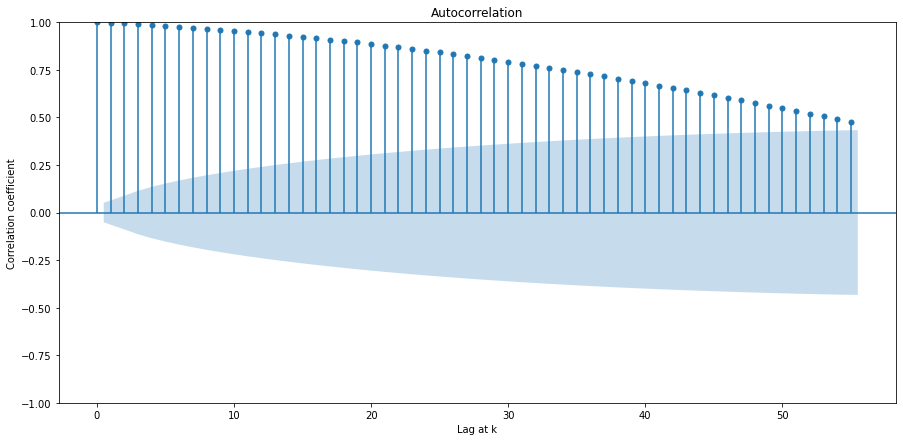

In [92]:
fig = plot_acf(temp_df['smoothed_out'], lags=55)
fig.set_size_inches((15, 7))
plt.xlabel("Lag at k")
plt.ylabel("Correlation coefficient")
plt.show()

In [93]:
temp_df['smoothed_out'].isna().sum()

0

In [ ]:
train_end = datetime(2016, 1, 3)
test_end = datetime(2016, 1, 11)

train_set = temp_df['smoothed_out'][:train_end]
test_set = temp_df['smoothed_out'][train_end: test_end]

ARMA_model = ARIMA(train_set, order=(0, 0, 56)) # the third value corresponds to number of lags
results = ARMA_model.fit()

In [95]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           smoothed_out   No. Observations:                 1098
Model:                ARIMA(0, 0, 56)   Log Likelihood                1022.709
Date:                Tue, 10 May 2022   AIC                          -1929.419
Time:                        19:29:29   BIC                          -1639.346
Sample:                    01-01-2013   HQIC                         -1819.672
                         - 01-03-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.8638      0.928     26.793      0.000      23.045      26.683
ma.L1          1.7699      0.017    102.955      0.000       1.736       1.804
ma.L2          2.4989      0.035     71.186      0.000       2.430       2.568
ma.L3          3.1269      0.059     52.589      0.000       3.010       3.243
ma.L4          3.7658      0.086     43.614      0.000       3.597       3.935
ma.L5          4.4605      0.116     38.306      0.000       4.232       4.689
ma.L6          5.1097      0.143     35.756      0.000       4.830       5.390
ma.L7          5.7016      0.169     33.650      0.000       5.369       6.034
ma.L8          6.3105      0.192     32.855      0.000       5.934       6.687
ma.L9          6.8344      0.215     31.748      0.000       6.412       7.256
ma.L10         7.2886      0.240     30.324      0.000       6.818       7.760
ma.L11         7.7720      0.266     29.237      0.000       7.251       8.293
ma.L12         8.2226      0.290     28.382      0.000       7.655       8.790
ma.L13         8.5930      0.310     27.750      0.000       7.986       9.200
ma.L14         8.9474      0.330     27.121      0.000       8.301       9.594
ma.L15         9.2609      0.351     26.391      0.000       8.573       9.949
ma.L16         9.4869      0.370     25.670      0.000       8.763      10.211
ma.L17         9.6871      0.386     25.090      0.000       8.930      10.444
ma.L18         9.7944      0.401     24.435      0.000       9.009      10.580
ma.L19         9.9436      0.418     23.798      0.000       9.125      10.763
ma.L20        10.1519      0.436     23.293      0.000       9.298      11.006
ma.L21        10.2485      0.453     22.610      0.000       9.360      11.137
ma.L22        10.3045      0.471     21.855      0.000       9.380      11.229
ma.L23        10.2445      0.489     20.938      0.000       9.286      11.203
ma.L24        10.2229      0.510     20.059      0.000       9.224      11.222
ma.L25        10.1510      0.531     19.119      0.000       9.110      11.192
ma.L26        10.0361      0.551     18.200      0.000       8.955      11.117
ma.L27         9.8761      0.569     17.350      0.000       8.760      10.992
ma.L28         9.6821      0.586     16.527      0.000       8.534      10.830
ma.L29         9.4213      0.598     15.753      0.000       8.249      10.593
ma.L30         9.1547      0.611     14.980      0.000       7.957      10.353
ma.L31         8.8581      0.623     14.213      0.000       7.637      10.080
ma.L32         8.5068      0.632     13.453      0.000       7.267       9.746
ma.L33         8.1497      0.639     12.757      0.000       6.898       9.402
ma.L34         7.8017      0.642     12.156      0.000       6.544       9.060
ma.L35         7.3880      0.641     11.530      0.000       6.132       8.644
ma.L36         7.0025      0.636     11.019      0.000       5.757       8.248
ma.L37         6.6251      0.627     10.569      0.000       5.396       7.854
ma

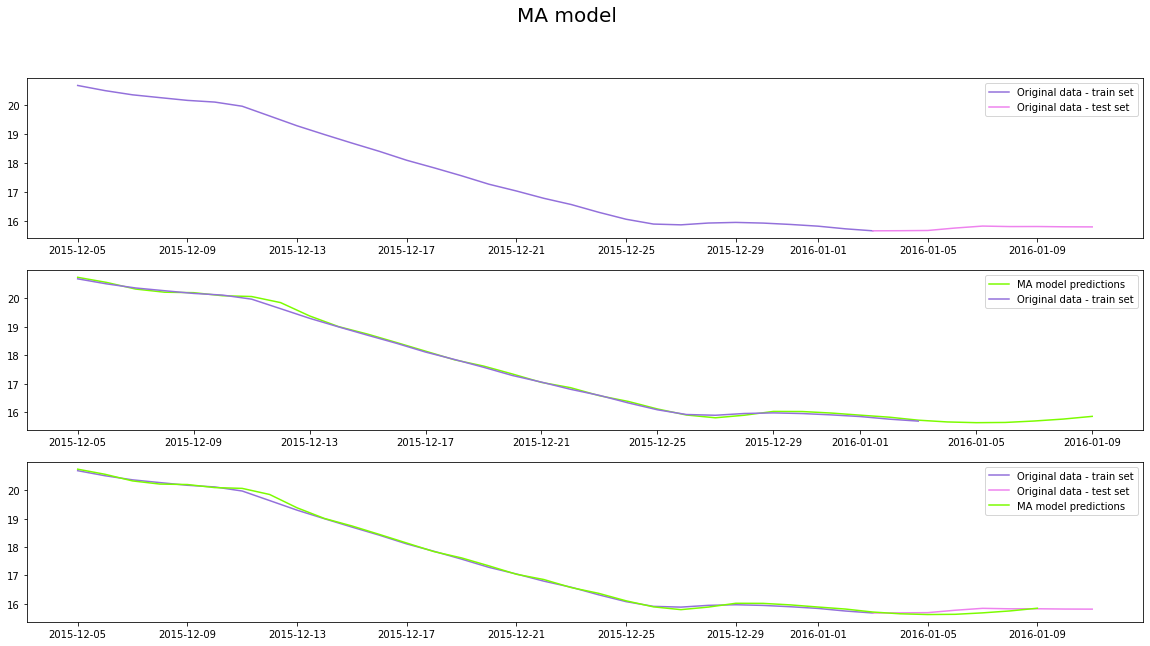

In [96]:
predictions = results.predict(start=train_set.index[-30], end=test_set.index[6])
plotting_predictions(predictions, train_set, test_set, setting_dict={'nosfts' : 30, 'model' : 'MA', 'y_lim' : None})

##### To remove the autocorrelation, we had to use multiple MA terms: $q = 56$, but if we look at the results, they are very similar to the actual values. Unfortunately, the trend of the projected data, if we look closely, starts to be too increasing and in the next projections we are likely to get temperatures that are higher than the actually observed values.

In [97]:
real_data_residuals = test_set - predictions
print(f'Mean Absolute Percent Error: {round(np.mean(abs(real_data_residuals/test_set)), 4)}')
print(f'Root Mean Squared Error:', round(np.sqrt(np.mean(real_data_residuals**2)), 4))

Mean Absolute Percent Error: 0.0048
Root Mean Squared Error: 0.0914


##### I am curious about next predictions, especially that I checked next real values in data set

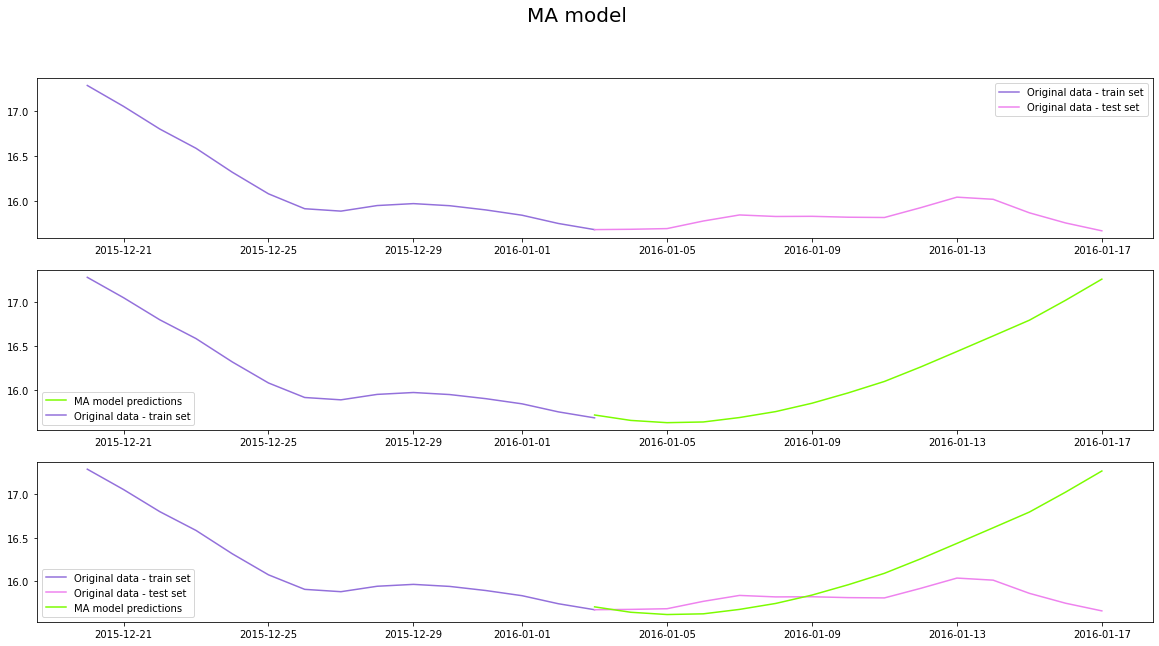

In [98]:
second_test_start = datetime(2016, 1, 3)
second_test_end = datetime(2016, 1, 17)
s_test_set = temp_df['smoothed_out'][second_test_start: second_test_end]

predictions = results.predict(start=s_test_set.index[0], end=s_test_set.index[-1])
plotting_predictions(predictions, train_set, s_test_set)

##### As I expected - predictions of temperatures started being too high compared to real values

##### Zadanie 3

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess, arma_generate_sample
from datetime import datetime, timedelta
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_predict

##### Generating artificial data

In [2]:
ar_params = np.array([0.75, -0.25])
ma_params = np.array([0.1, 0.35])

number_of_samples = 500

np.random.seed(420)
generated_samples = arma_generate_sample(np.r_[1, -ar_params], np.r_[1, ma_params], number_of_samples)

In [3]:
dates = pd.date_range('2004-5-1', freq='D', periods=number_of_samples)
df_data = pd.DataFrame(generated_samples, index=dates, columns=['values'])
df_data.head()

,values
2004-05-01,-0.485391
2004-05-02,-2.317736
2004-05-03,-2.503578
2004-05-04,-2.331222
2004-05-05,-1.007347


<AxesSubplot:>

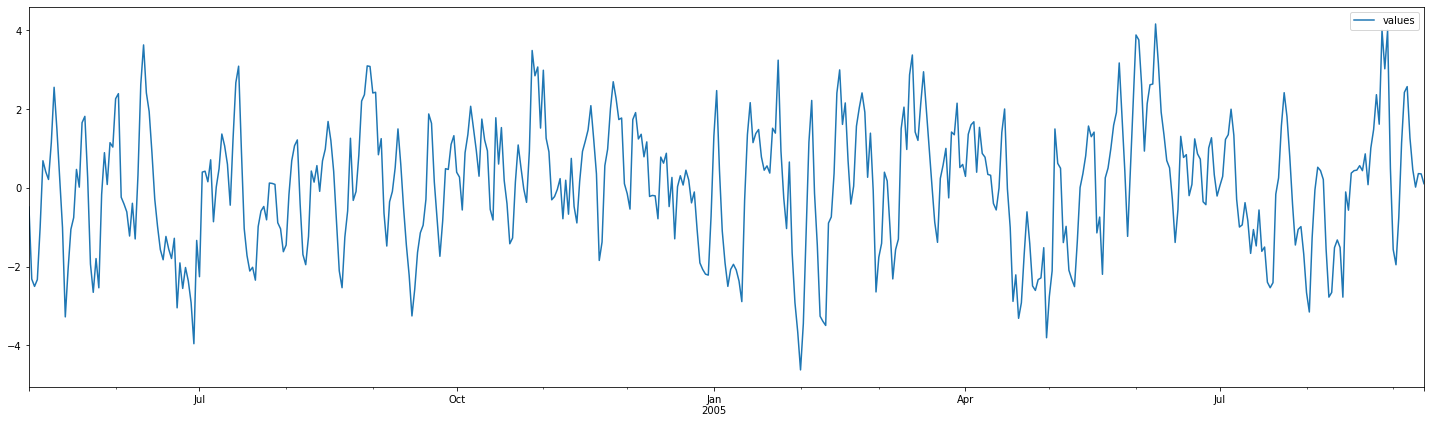

In [4]:
df_data.plot(figsize=(25, 7))

##### Let's see how does partial correlation looks like, because we need to set appriopriate order of the AR term (p). Partial autocorrelation can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. So, PACF sort of conveys the pure correlation between a lag and the series.

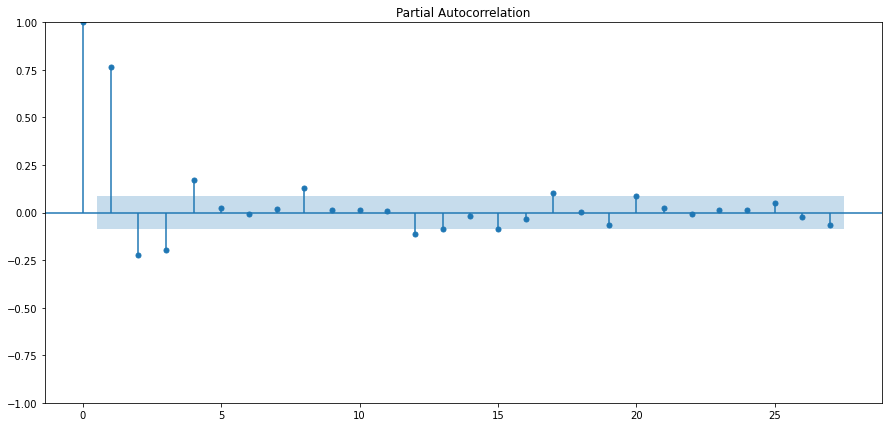

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
plot_pacf(df_data, ax=ax, method='ywm')
plt.show()

##### When we look at plot, in my opinion choosing the first lag (p = 1) is a good choice.

##### We are supposed to choose order of the MA term (q) also. To do this we will look at autocorrelation plot

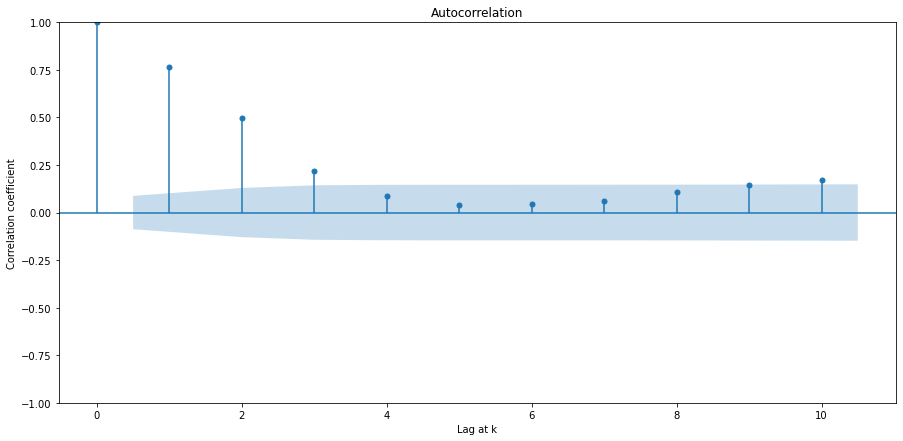

In [6]:
fig = plot_acf(df_data, lags=10)
fig.set_size_inches((15, 7))
plt.xlabel("Lag at k")
plt.ylabel("Correlation coefficient")
plt.show()

##### Let's choose q equal to 3

##### It is time to divide our data into train and test set. Then, we will create a model and see how accurate predictions we will get.

In [7]:
train_set = df_data['values'][:int(len(df_data) * 0.8)]
test_set = df_data['values'][int(len(df_data) * 0.8) - 1 : ]

In [8]:
model_1 = ARIMA(train_set, order=(1, 0, 3))
fitted_model_1 = model_1.fit()
print(fitted_model_1.summary())

                               SARIMAX Results                                
Dep. Variable:                 values   No. Observations:                  400
Model:                 ARIMA(1, 0, 3)   Log Likelihood                -563.814
Date:                Fri, 20 May 2022   AIC                           1139.629
Time:                        16:08:32   BIC                           1163.578
Sample:                    05-01-2004   HQIC                          1149.113
                         - 06-04-2005                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0300      0.167      0.180      0.857      -0.297       0.357
ar.L1          0.3784      0.154      2.459      0.014       0.077       0.680
ma.L1          0.5310      0.156      3.406      0.0

##### We can check whether choosing a little bit different p or q would result in better model.

In [9]:
model_2 = ARIMA(train_set, order=(1, 0, 2))
fitted_model_2 = model_2.fit()
print(fitted_model_2.summary())

                               SARIMAX Results                                
Dep. Variable:                 values   No. Observations:                  400
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -564.128
Date:                Fri, 20 May 2022   AIC                           1138.256
Time:                        16:09:32   BIC                           1158.213
Sample:                    05-01-2004   HQIC                          1146.159
                         - 06-04-2005                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0295      0.172      0.172      0.864      -0.307       0.366
ar.L1          0.4680      0.066      7.080      0.000       0.338       0.598
ma.L1          0.4342      0.065      6.647      0.0

In [12]:
model_3 = ARIMA(train_set, order=(2, 0, 2))
fitted_model_3 = model_3.fit()
print(fitted_model_3.summary())

                               SARIMAX Results                                
Dep. Variable:                 values   No. Observations:                  400
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -563.750
Date:                Fri, 20 May 2022   AIC                           1139.499
Time:                        16:09:58   BIC                           1163.448
Sample:                    05-01-2004   HQIC                          1148.983
                         - 06-04-2005                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0299      0.164      0.182      0.856      -0.292       0.352
ar.L1          0.5890      0.151      3.896      0.000       0.293       0.885
ar.L2         -0.1086      0.124     -0.878      0.3

##### The most significant coefficients can be found in the second summary, so p has been chosen correctly, but we need to increase q.

In [114]:
predictions_artificial_data = fitted_model_3.predict(start=train_set.index[-40], end=train_set.index[-1])

In [116]:
from plotting_f import plotting_predictions, comparing_results

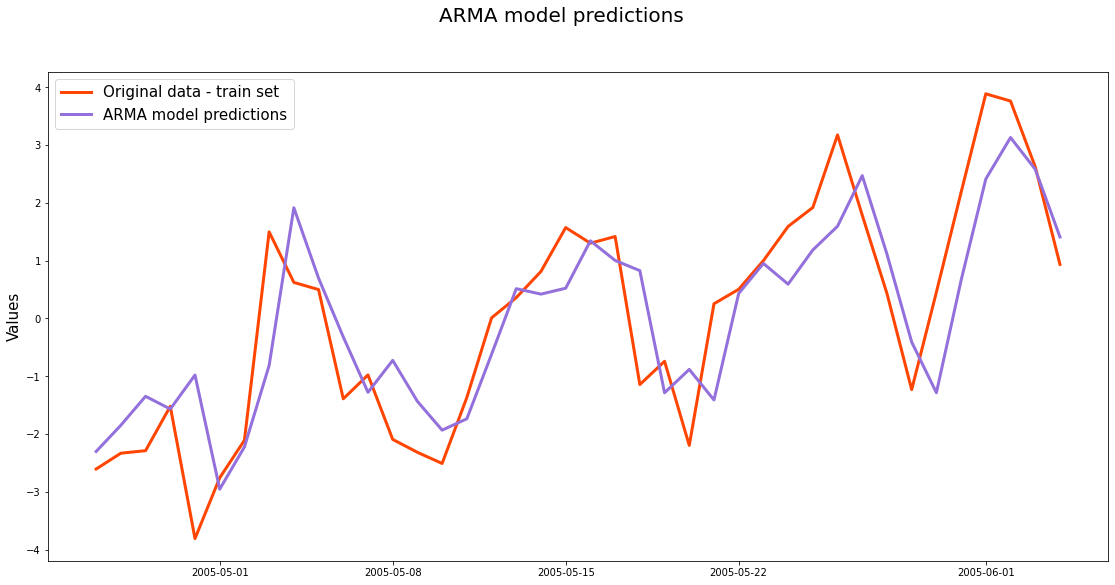

In [117]:
plotting_predictions(predictions_artificial_data, train_set=train_set, test_set=test_set, pred_type='predictions', n_train_samples = 40, model_type = 'ARMA', y_lim = None)

##### The predictions from the created model look similar to the actual values, however, we can easily observe some differences - alternately the predicted values are once slightly higher and once slightly lower. In the next step we will try to predict some data

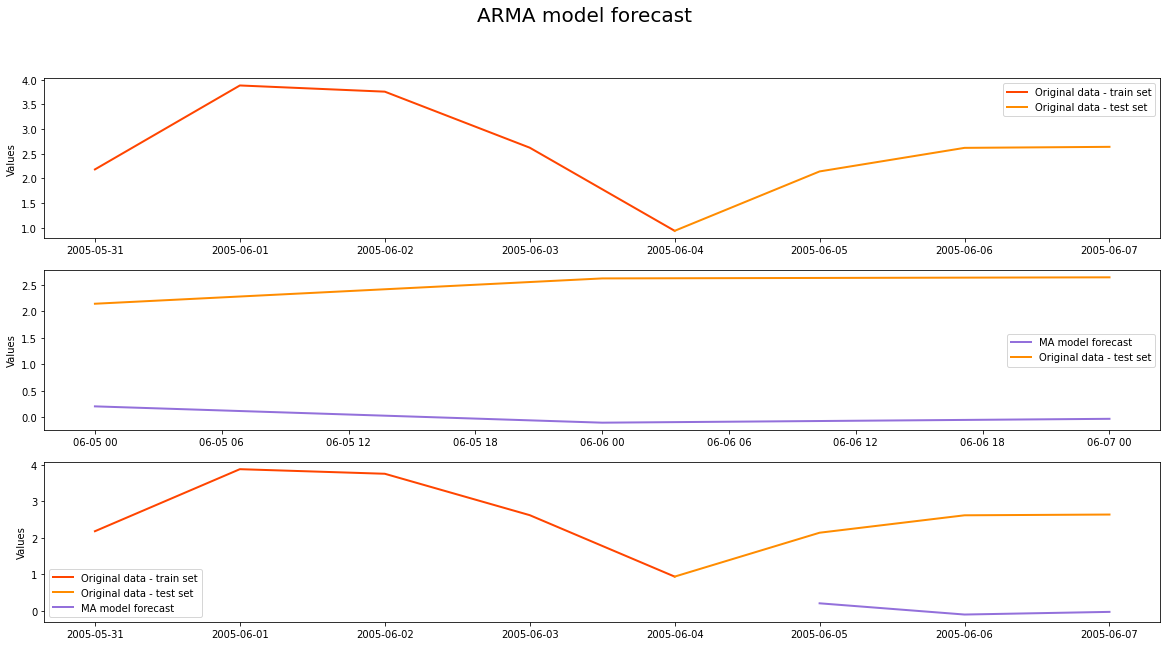

In [118]:
forecast_artificial_data = fitted_model_1.forecast(3, alpha=0.05)
plotting_predictions(forecast_artificial_data, train_set=train_set, test_set=test_set[:4], pred_type='forecast', n_train_samples = 5, model_type = 'ARMA', y_lim = [-4, 3])

##### They are quite similar to the actual values, but if we wanted to forecast more values, they would tend to be constant

##### Let's compare our results with the AR and MA model

In [119]:
from statsmodels.tsa.ar_model import AutoReg

In [120]:
AR_model = model_AR = AutoReg(train_set, lags=2)
fitted_ar_model = model_AR.fit()
print(fitted_ar_model.summary())

preds_AR_model = fitted_ar_model.predict(start=train_set.index[-40], end=train_set.index[-1])

                            AutoReg Model Results                             
Dep. Variable:                 values   No. Observations:                  400
Model:                     AutoReg(2)   Log Likelihood                -573.112
Method:               Conditional MLE   S.D. of innovations              1.021
Date:                Tue, 10 May 2022   AIC                           1154.225
Time:                        19:51:51   BIC                           1170.171
Sample:                    05-03-2004   HQIC                          1160.541
                         - 06-04-2005                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0146      0.051      0.285      0.775      -0.086       0.115
values.L1      0.9284      0.049     19.057      0.000       0.833       1.024
values.L2     -0.2228      0.049     -4.559      0.0

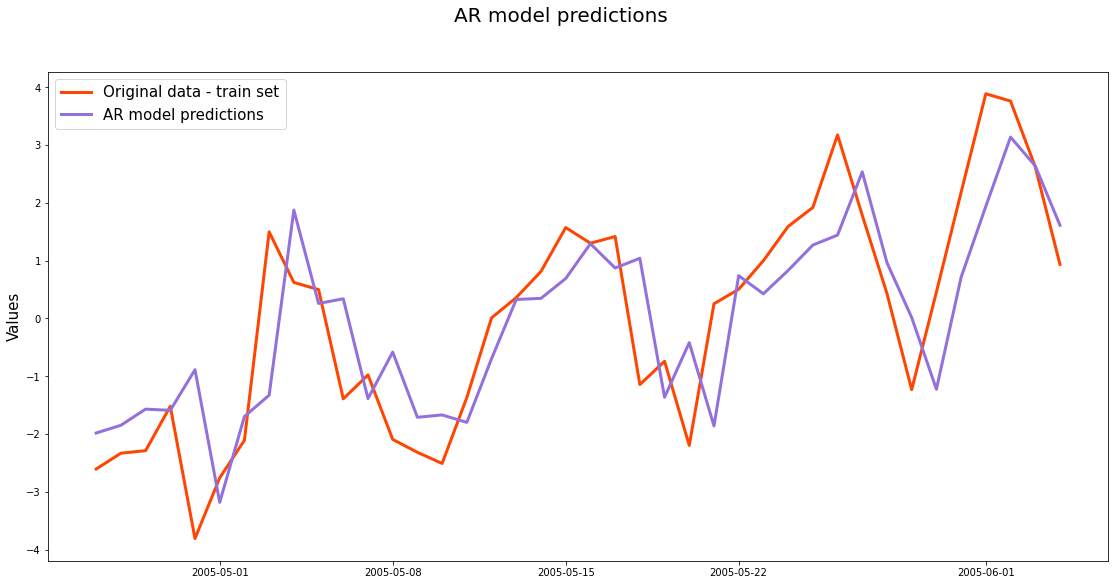

In [121]:
plotting_predictions(preds_AR_model, train_set=train_set, test_set=test_set, pred_type='predictions', n_train_samples = 40, model_type = 'AR', y_lim = None)

In [122]:
ARMA_model = ARIMA(train_set, order=(0, 0, 2)) # the third value corresponds to number of lags
fitted_MA_model = ARMA_model.fit()
print(fitted_MA_model.summary())

preds_MA_model = fitted_MA_model.predict(start=train_set.index[-40], end=train_set.index[-1])

                               SARIMAX Results                                
Dep. Variable:                 values   No. Observations:                  400
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -582.431
Date:                Tue, 10 May 2022   AIC                           1172.862
Time:                        19:51:51   BIC                           1188.828
Sample:                    05-01-2004   HQIC                          1179.185
                         - 06-04-2005                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0296      0.119      0.248      0.804      -0.204       0.264
ma.L1          0.7605      0.042     18.271      0.000       0.679       0.842
ma.L2          0.5389      0.043     12.533      0.0

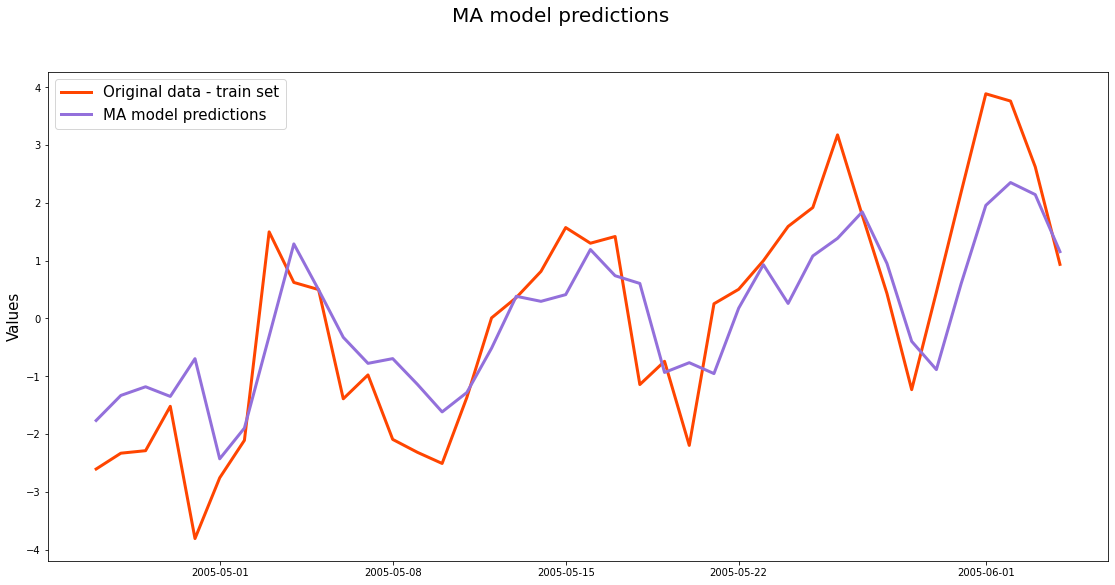

In [123]:
plotting_predictions(preds_MA_model, train_set=train_set, test_set=test_set, pred_type='predictions', n_train_samples = 40, model_type = 'MA', y_lim = None)

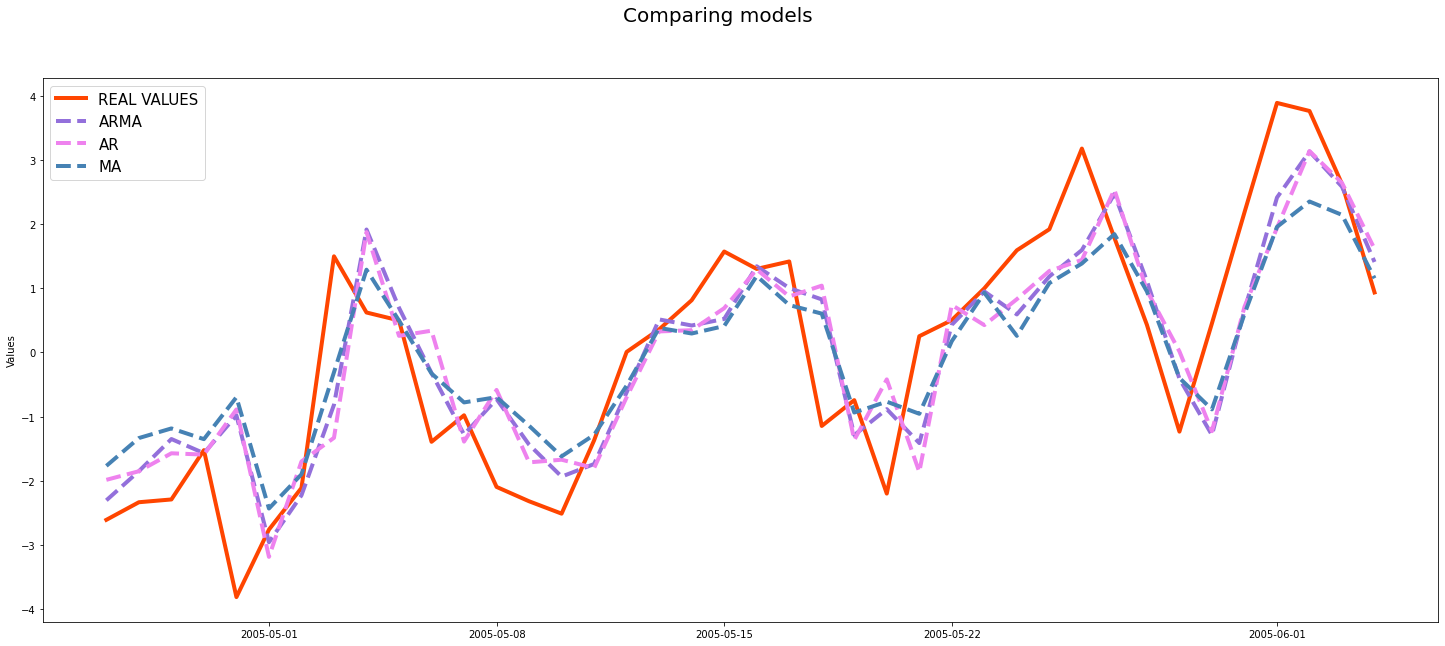

In [124]:
comparing_results(train_set[-40:], {'arma' : predictions_artificial_data, 'ar' : preds_AR_model, 'ma' : preds_MA_model})

##### It is hard to say which model predicted the values closest to the actual values. It is interesting to note that the results for the ARMA and AR models are almost identical - only slightly different in some places in the graph above. To see which model performed best, we would calculate the mean absolute percentage error. We could also measure the mean square error, since each model worked on the same data.

In [125]:
residuals_for_all_models = []
models = ['ARMA', 'AR', 'MA']
for preds, model in zip([predictions_artificial_data, preds_AR_model, preds_MA_model], models):
    resid = train_set[-40:] - preds
    residuals_for_all_models += [resid]
    print(f'Mean Absolute Percent Error for {model} model: {round(np.mean(abs(resid / train_set[-40:])), 4)}')

Mean Absolute Percent Error for ARMA model: 2.5616
Mean Absolute Percent Error for AR model: 2.8832
Mean Absolute Percent Error for MA model: 2.1615


##### I am somewhat surprised by the results - the MA model performed better than the ARMA and AR model. Although the differences between the criteria for all models are not large, a model that has too little practical use without the AR part performed better than a model that consists of just that part (ARMA).

##### Let us now turn to the actual data - we will again use the 2013-2016 Delhi climate change dataset, but this time we will focus on humidity.

In [126]:
file_name = 'DailyDelhiClimateTrain.csv'
climate_df = pd.read_csv(file_name, index_col=0, parse_dates=True)
climate_df.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [127]:
humidity_df = climate_df.drop(['meantemp', 'wind_speed', 'meanpressure'], axis=1)
humidity_df.head(5)

,humidity
date,
2013-01-01,84.500000
2013-01-02,92.000000
2013-01-03,87.000000
2013-01-04,71.333333
2013-01-05,86.833333


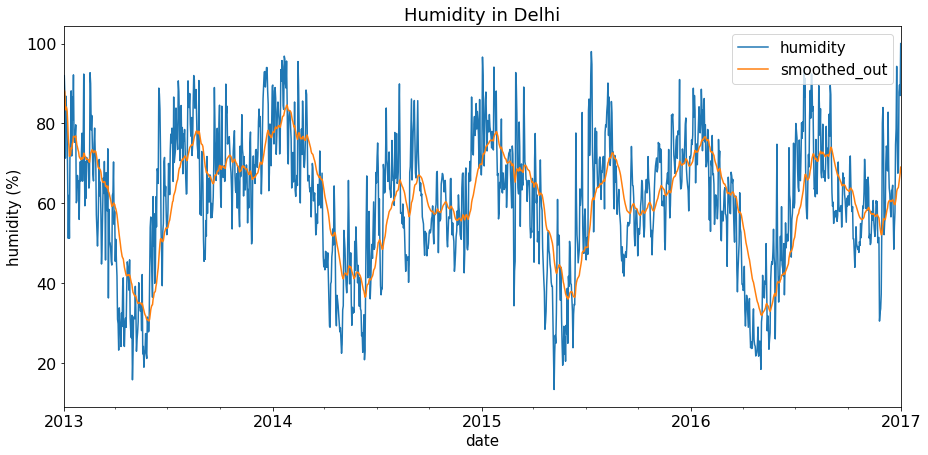

In [128]:
humidity_df.insert(1, 'smoothed_out', humidity_df['humidity'].ewm(alpha=0.05).mean())
plt.rcParams.update({'font.size': 15})
humidity_df.plot(figsize=(15, 7), title='Humidity in Delhi', ylabel='humidity (%)', fontsize=16)
plt.show()

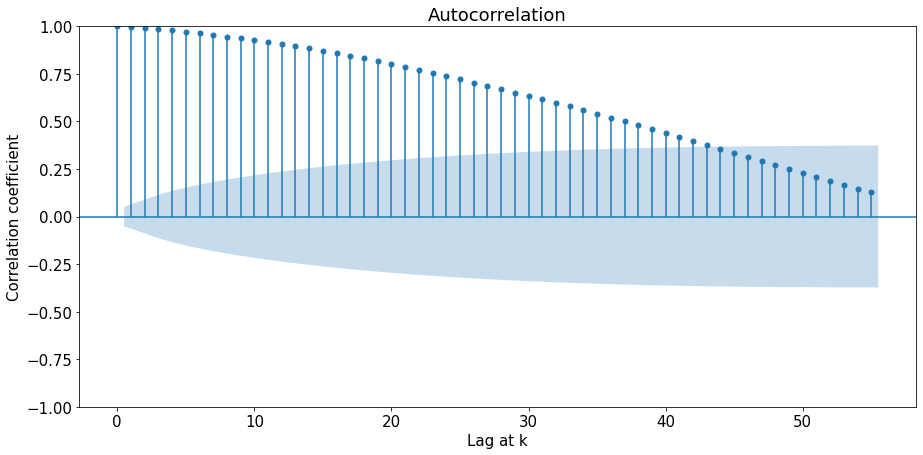

In [129]:
fig = plot_acf(humidity_df['smoothed_out'], lags=55)
fig.set_size_inches((15, 7))
plt.xlabel("Lag at k")
plt.ylabel("Correlation coefficient")
plt.show()

##### Differencing would help us a lot, but we will deal with this in the next task (ARIMA model). We will choose the best q when fitting the model

In [130]:
from statsmodels.tsa.stattools import adfuller
p_value = adfuller(humidity_df['smoothed_out'].values)[1]

print(f' p value : {p_value.round(5)} < 0.05, so we reject hypothesis that time series is not stationary.')

 p value : 0.00019 < 0.05, so we reject hypothesis that time series is not stationary.


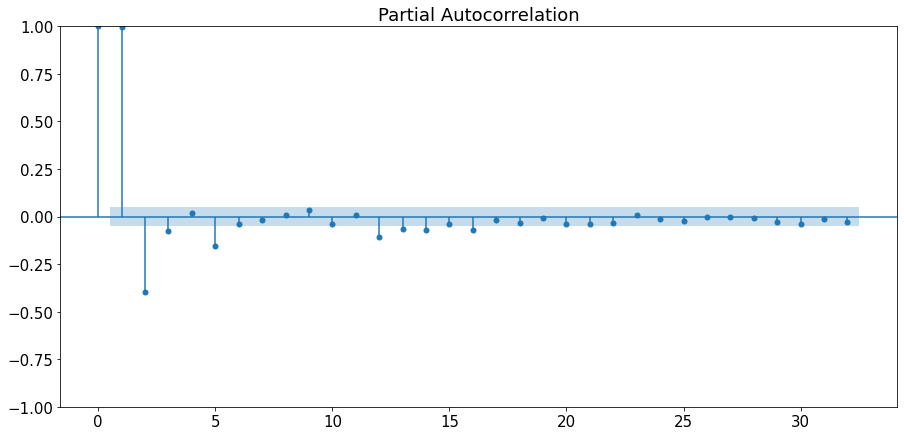

In [131]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
plot_pacf(humidity_df['smoothed_out'], ax=ax, method='ywm')
plt.show()

##### Let's set p order to 2

In [132]:
train_end = datetime(2016, 1, 3)
test_end = datetime(2016, 1, 11)

train_set_real_data = humidity_df['smoothed_out'][:train_end]
test_set_real_data = humidity_df['smoothed_out'][train_end: test_end]

In [ ]:
ARMA_model = ARIMA(train_set_real_data, order=(2, 0, 4))
fitted_ARMA_model = ARMA_model.fit()

In [134]:
fitted_ARMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           smoothed_out   No. Observations:                 1098
Model:                 ARIMA(2, 0, 4)   Log Likelihood                -733.634
Date:                Tue, 10 May 2022   AIC                           1483.269
Time:                        19:51:54   BIC                           1523.279
Sample:                    01-01-2013   HQIC                          1498.406
                         - 01-03-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         62.7868      2.469     25.428      0.000      57.947      67.626
ar.L1          1.9781      0.010    203.168      0.000       1.959       1.997
ar.L2         -0.9790      0.010   -101.510      0.000      -0.998      -0.960
ma.L1         -0.3080      0.020    -15.654      0.000      -0.347      -0.269
ma.L2         -0.2700      0.019    -14.437      0.000      -0.307      -0.233
ma.L3         -0.2160      0.015    -14.098      0.000      -0.246      -0.186
ma.L4         -0.0612      0.015     -3.985      0.000      -0.091      -0.031
sigma2         0.2211      0.004     50.118      0.000       0.212       0.230
===================================================================================
Ljung-Box (L1) (Q):                   0.54   Jarque-Bera (JB):              5589.79
Prob(Q):                              0.46   Prob(JB):                         0.00
Heteroskedasticity (H):               0.40   Skew:                             0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

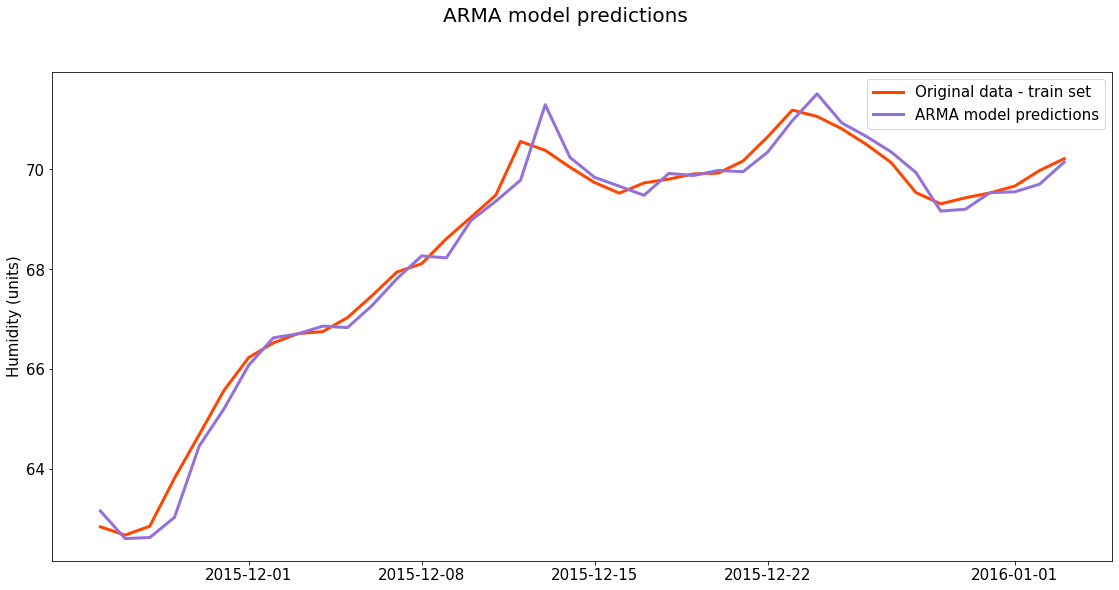

In [135]:
preds_ARMA_model_real_data = fitted_ARMA_model.predict(start=train_set_real_data.index[-40], end=train_set_real_data.index[-1])
plotting_predictions(preds_ARMA_model_real_data, train_set=train_set_real_data, test_set=test_set_real_data, pred_type='predictions', n_train_samples = 40, model_type = 'ARMA', y_lim = None, y_label = 'Humidity (units)')


##### Let's compare our results

In [136]:
from statsmodels.tsa.ar_model import AutoReg
AR_model = model_AR = AutoReg(train_set_real_data, lags=2)
fitted_ar_model = model_AR.fit()
print(fitted_ar_model.summary())

preds_AR_model_real_data = fitted_ar_model.predict(start=train_set_real_data.index[-40], end=train_set_real_data.index[-1])


                            AutoReg Model Results                             
Dep. Variable:           smoothed_out   No. Observations:                 1098
Model:                     AutoReg(2)   Log Likelihood                -723.236
Method:               Conditional MLE   S.D. of innovations              0.468
Date:                Tue, 10 May 2022   AIC                           1454.472
Time:                        19:51:54   BIC                           1474.470
Sample:                    01-03-2013   HQIC                          1462.039
                         - 01-03-2016                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1994      0.073      2.744      0.006       0.057       0.342
smoothed_out.L1     1.6652      0.022     76.554      0.000       1.623       1.708
smoothed_out.L2    -0.6686      

c:\Users\matys\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [ ]:
MA_model = ARIMA(train_set_real_data, order=(0, 0, 4)) # the third value corresponds to number of lags
fitted_MA_model = MA_model.fit()
print(fitted_MA_model.summary())

preds_MA_model_real_data = fitted_MA_model.predict(start=train_set_real_data.index[-40], end=train_set_real_data.index[-1])

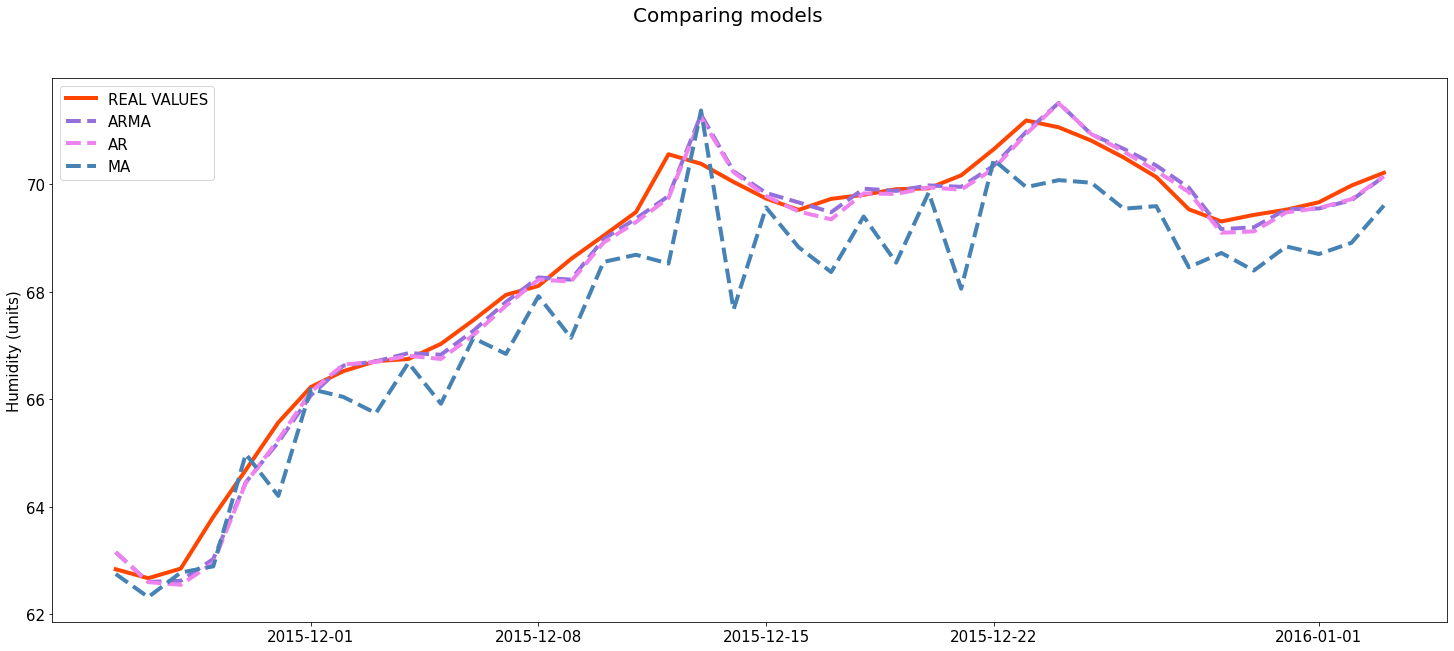

In [138]:
comparing_results(train_set_real_data[-40:], {'arma' : preds_ARMA_model_real_data, 'ar' : preds_AR_model_real_data, 'ma' : preds_MA_model_real_data}, y_label='Humidity (units)')

In [139]:
residuals_for_all_models = []
models = ['ARMA', 'AR', 'MA']
for preds, model in zip([preds_ARMA_model_real_data, preds_AR_model_real_data, preds_MA_model_real_data], models):
    resid = train_set_real_data[-40:] - preds
    residuals_for_all_models += [resid]
    print(f'Mean Absolute Percent Error for {model} model: {round(np.mean(abs(resid / train_set_real_data[-40:])), 4)}')

Mean Absolute Percent Error for ARMA model: 0.0033
Mean Absolute Percent Error for AR model: 0.0035
Mean Absolute Percent Error for MA model: 0.0118


##### When dealing with real data, the MA model worked best. However, this time I did not change the p-order for the ARMA model or the q-order for the MA model, which of course could have affected the results. The average absolute percentage error for the ARMA and AR models are almost identical, but in this case the MA model performed about 4 times worse than the others. In many cases the MA model predictions were lower than the actual values.

##### Zadanie 4

In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess, arma_generate_sample
from datetime import datetime, timedelta
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_predict

##### First, we will carry out a similar procedure as in the previous task

In [141]:
import statsmodels.api as sm

df_data = sm.datasets.co2.load_pandas()
df_data = pd.DataFrame(df_data.data)
df_data.head(20)

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4
1958-05-03,316.9
1958-05-10,NaN
1958-05-17,317.5
1958-05-24,317.9
1958-05-31,NaN


In [142]:
df_data.isna().sum()

co2    59
dtype: int64

##### There are some missing values, so we can use interpolation

In [143]:
df_data = df_data.interpolate()
df_data.isna().sum()

co2    0
dtype: int64

<AxesSubplot:ylabel='CO2 Concentration'>

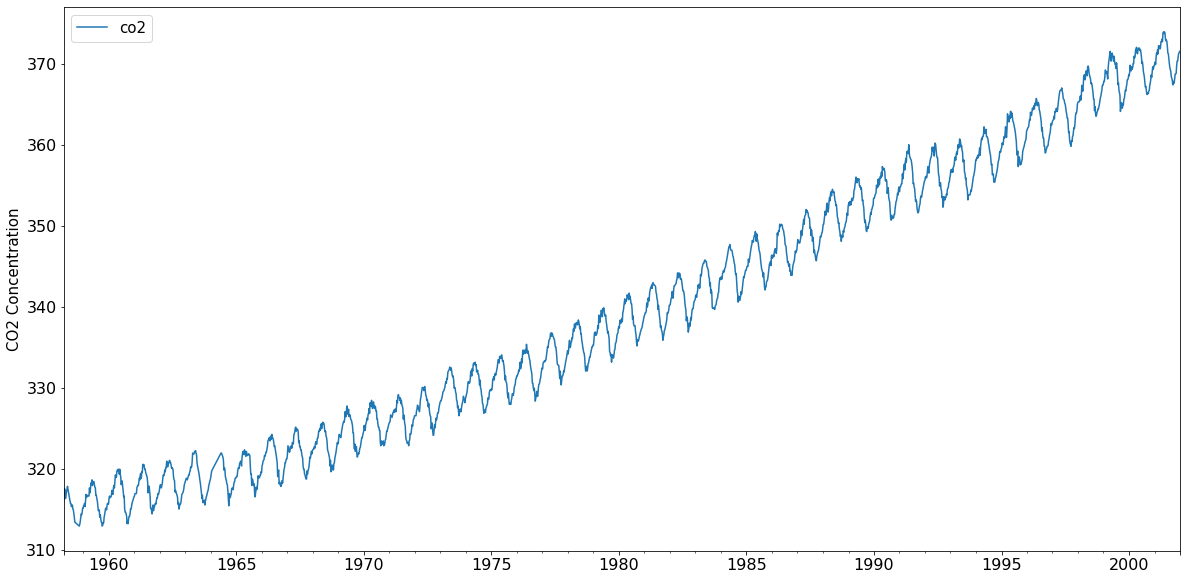

In [144]:
df_data.plot(figsize=(20, 10), ylabel='CO2 Concentration', fontsize=16)

In [145]:
from statsmodels.tsa.stattools import adfuller

p_value = adfuller(df_data.values)[1]
print(f'P value is equal to {p_value.round(4)}, so this time series is not stationary')

P value is equal to 0.9612, so this time series is not stationary


##### This time we will first choose the appropriate differencing order, which is d in the ARIMA(p, d, q) model.

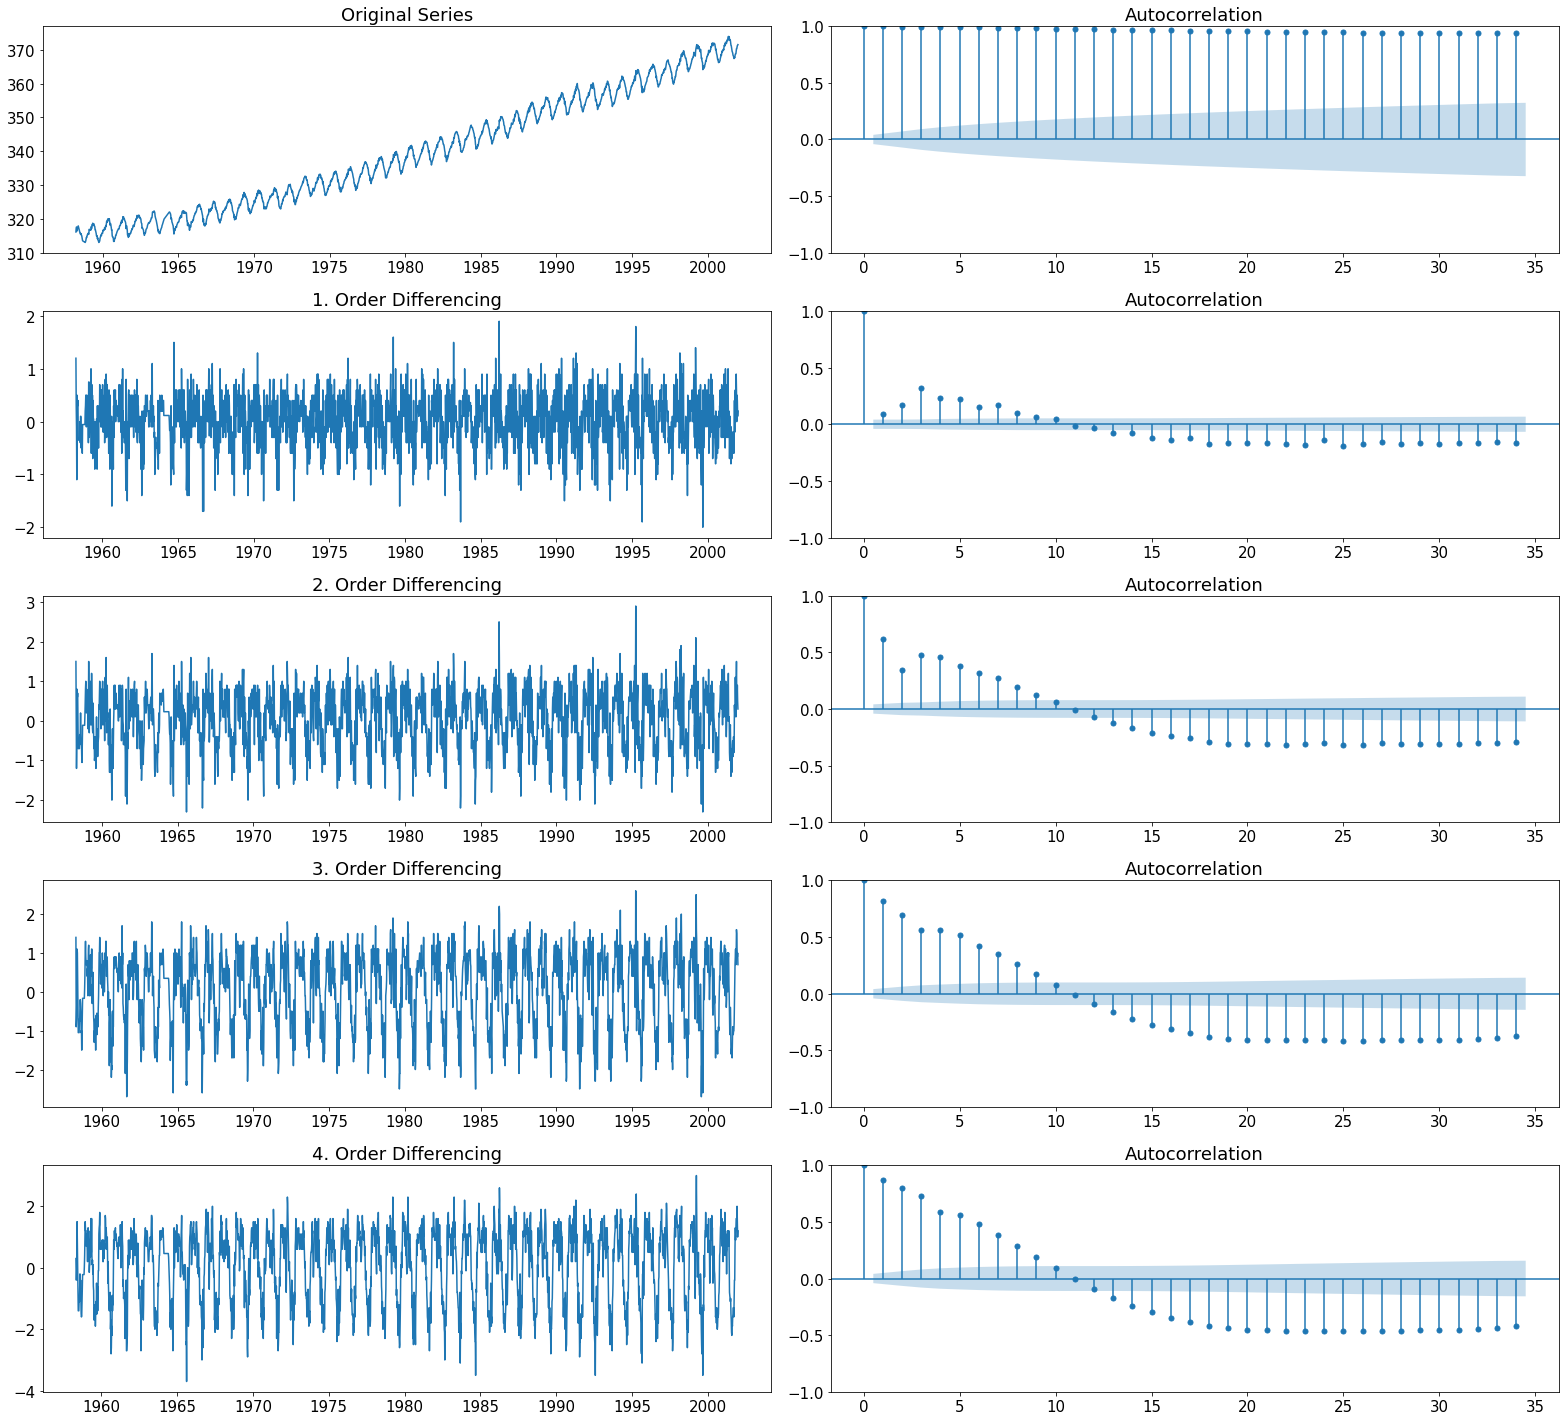

In [159]:
fig, axes = plt.subplots(5, 2, figsize=(22, 20))
for i in range(0, 5):
    if i == 0:
        title = 'Original Series'
        axes[i, 0].plot(df_data)
        axes[i, 0].set_title(title)
        plot_acf(df_data, ax=axes[i, 1])
    else:
        title = f'{i}. Order Differencing'
        axes[i, 0].plot(df_data.diff(i).dropna())
        axes[i, 0].set_title(title)
        plot_acf(df_data.diff(i).dropna(), ax=axes[i, 1])
        
plt.tight_layout()
plt.show()


##### It is hard to say, but the best choice seems to be the second or third differentiation. If we look at the first differentiation, we can see that the autocorrelation values fall too fast, so we can end up with a time series that is too differentiated. 

##### Checking for partial correlation - choice of p order

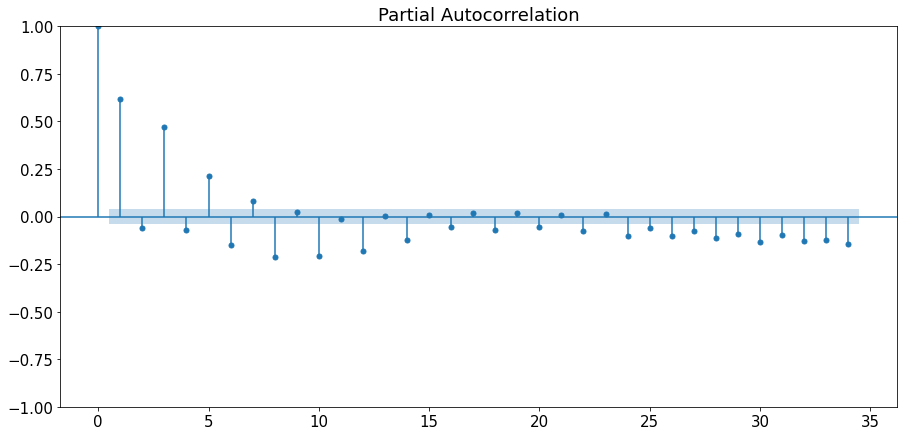

In [147]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
plot_pacf(df_data.diff(2).dropna(), ax=ax, method='ywm')
plt.show()

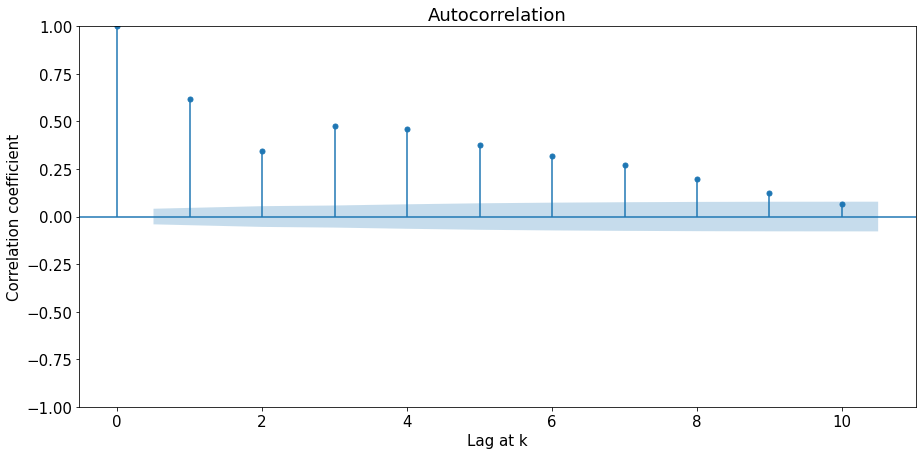

In [148]:
fig = plot_acf(df_data.diff(2).dropna(), lags=10)
fig.set_size_inches((15, 7))
plt.xlabel("Lag at k")
plt.ylabel("Correlation coefficient")
plt.show()

##### This seems to be no easy task - we will try to determine the best parameters for our ARIMA model by trial and error.

In [149]:
train_set = df_data[:int(len(df_data) * 0.8)]
test_set = df_data[int(len(df_data) * 0.8) - 1 : ]

In [150]:
model_ARIMA = ARIMA(train_set, order=(3, 1, 5))
fitted_model_ARIMA =model_ARIMA.fit()
print(fitted_model_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                    co2   No. Observations:                 1827
Model:                 ARIMA(3, 1, 5)   Log Likelihood               -1001.574
Date:                Tue, 10 May 2022   AIC                           2021.148
Time:                        20:06:37   BIC                           2070.737
Sample:                    03-29-1958   HQIC                          2039.440
                         - 03-27-1993                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9412      0.064     14.651      0.000       0.815       1.067
ar.L2          0.9687      0.123      7.891      0.000       0.728       1.209
ar.L3         -0.9453      0.062    -15.330      0.0

c:\Users\matys\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


##### After many attempts I think I have found the best model. At first, I mistakenly thought that choosing $d = 1$ was not a good choice. The most significant coefficients can be obtained by setting: $d = 1, p = 3, q = 5$.

In [151]:
arima_predictions = fitted_model_ARIMA.predict(start=train_set.index[-400], end=train_set.index[-5])

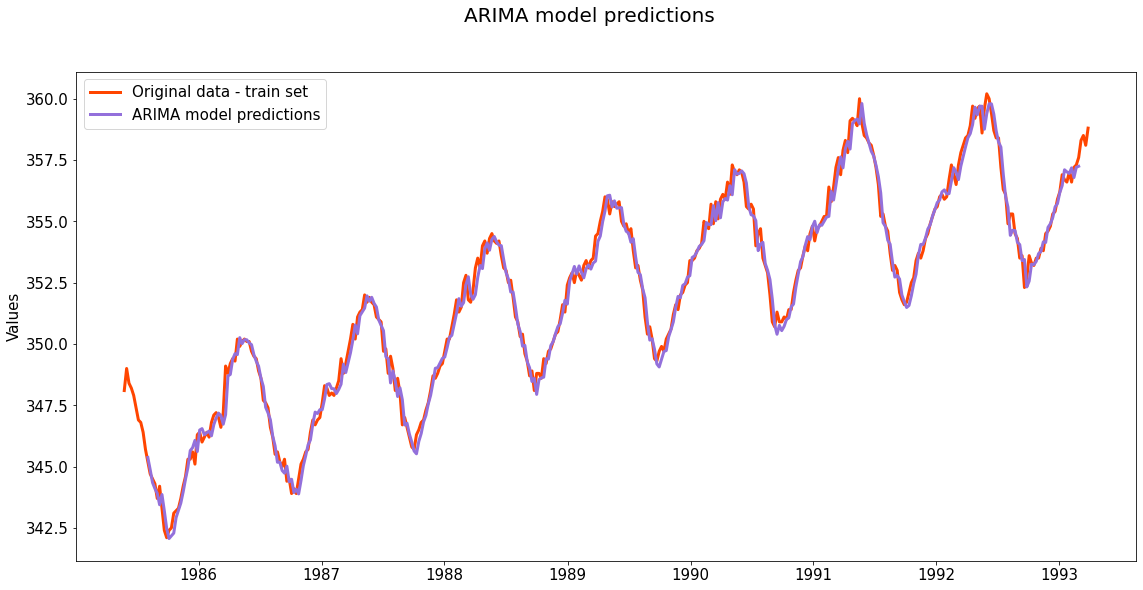

In [152]:
from plotting_f import plotting_predictions, comparing_results

plotting_predictions(arima_predictions, train_set=train_set, test_set=test_set, pred_type='predictions', n_train_samples = 410, model_type = 'ARIMA', y_lim = None)

##### The predictions are almost identical to the actual values, but it is interesting to see how it looks when we focus on a narrower range.

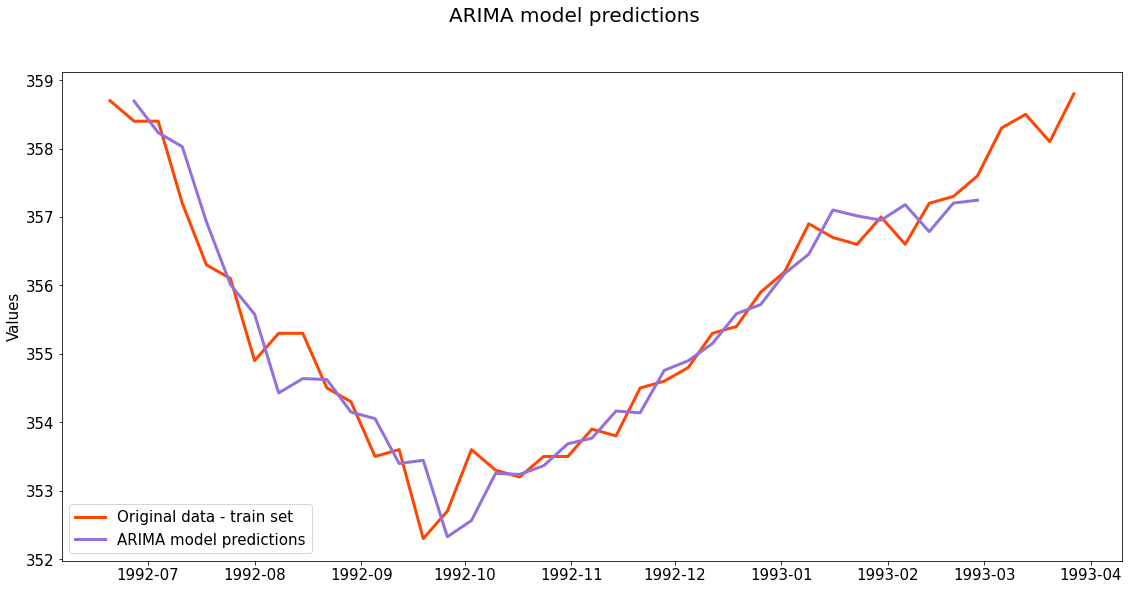

In [183]:
arima_predictions_n_i = fitted_model_ARIMA.predict(start=train_set.index[-40], end=train_set.index[-5])
plotting_predictions(arima_predictions_n_i, train_set=train_set, test_set=test_set, pred_type='predictions', n_train_samples = 41, model_type = 'ARIMA', y_lim = None)

##### Predictions are very close to the actual values, now let's see how the SARIMA model will work.

In [ ]:
import statsmodels as sm

SARIMA_model = sm.tsa.statespace.sarimax.SARIMAX(train_set, order=(3, 1, 5), seasonal_order=(1, 1, 1, 12))
fitted_SARIMA_model = SARIMA_model.fit()
print(fitted_SARIMA_model.summary())

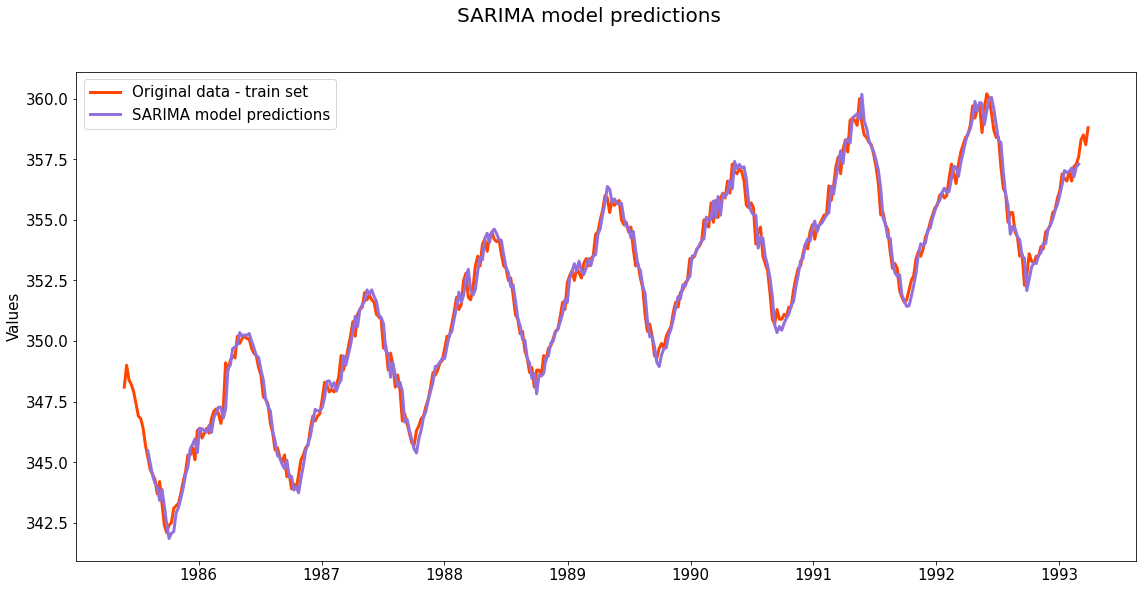

In [181]:
sarima_predictions = fitted_SARIMA_model.predict(start=train_set.index[-400], end=train_set.index[-5])
plotting_predictions(sarima_predictions, train_set=train_set, test_set=test_set, pred_type='predictions', n_train_samples = 410, model_type = 'SARIMA', y_lim = None)

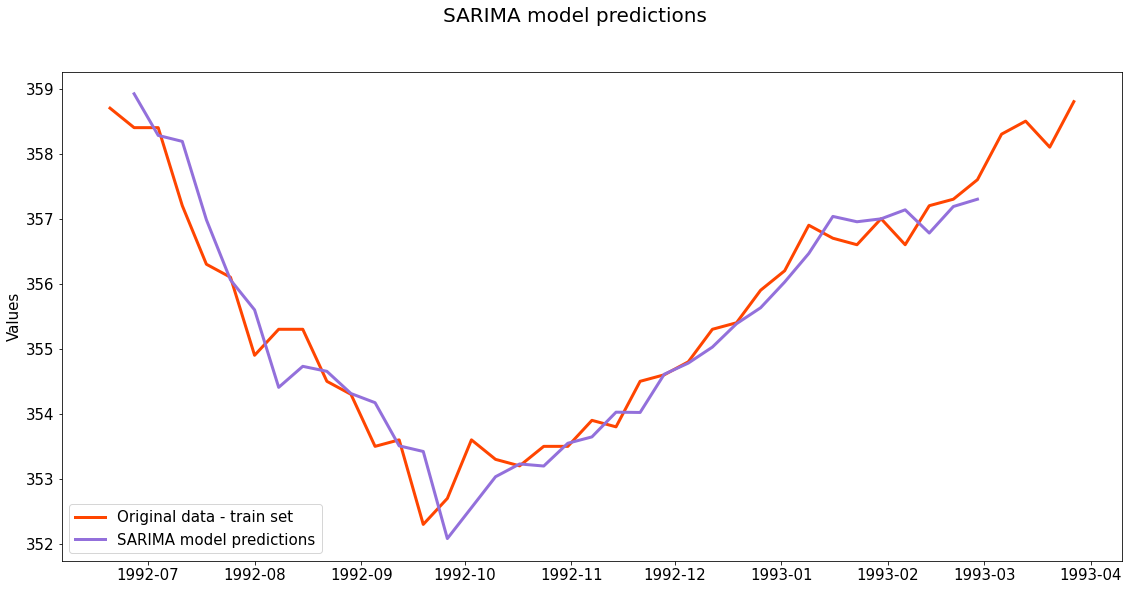

In [182]:
sarima_predictions_n_i = fitted_SARIMA_model.predict(start=train_set.index[-40], end=train_set.index[-5])
plotting_predictions(sarima_predictions_n_i, train_set=train_set, test_set=test_set, pred_type='predictions', n_train_samples = 41, model_type = 'SARIMA', y_lim = None)

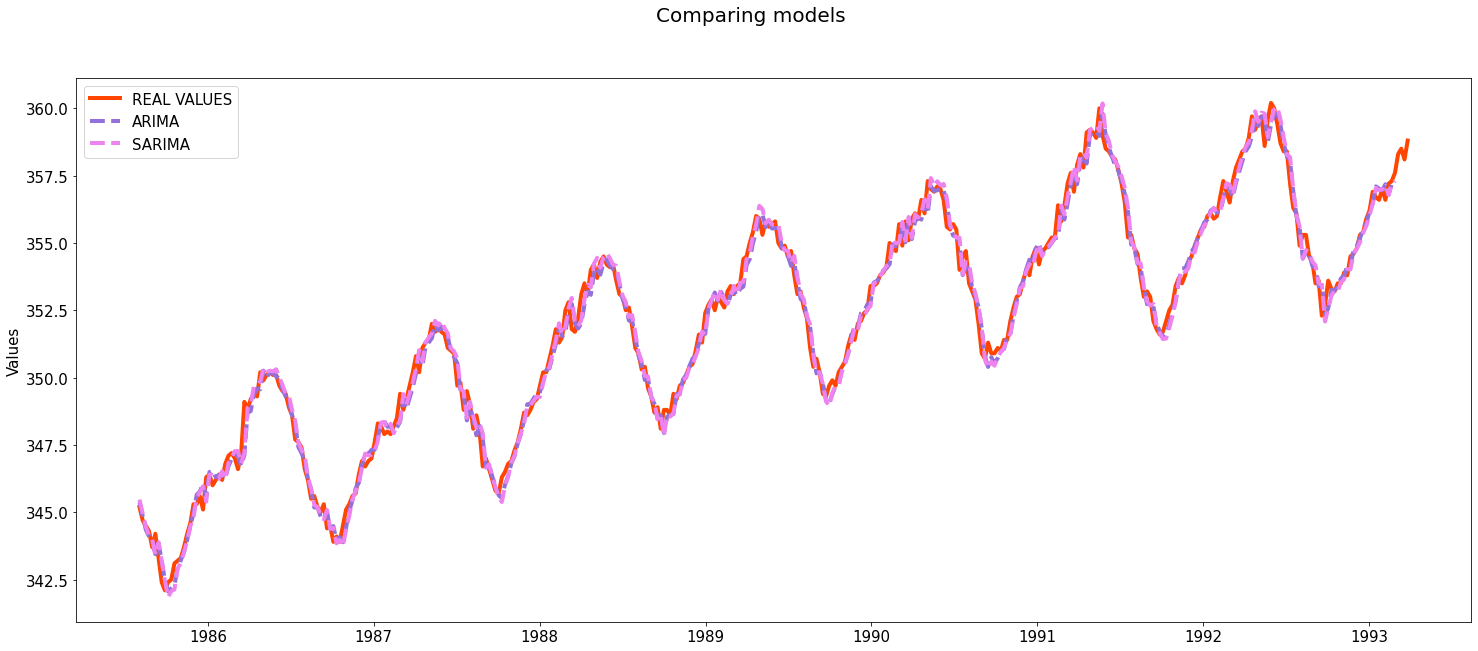

In [157]:
comparing_results(train_set[-400:], {'arima' : arima_predictions, 'sarima' : sarima_predictions})

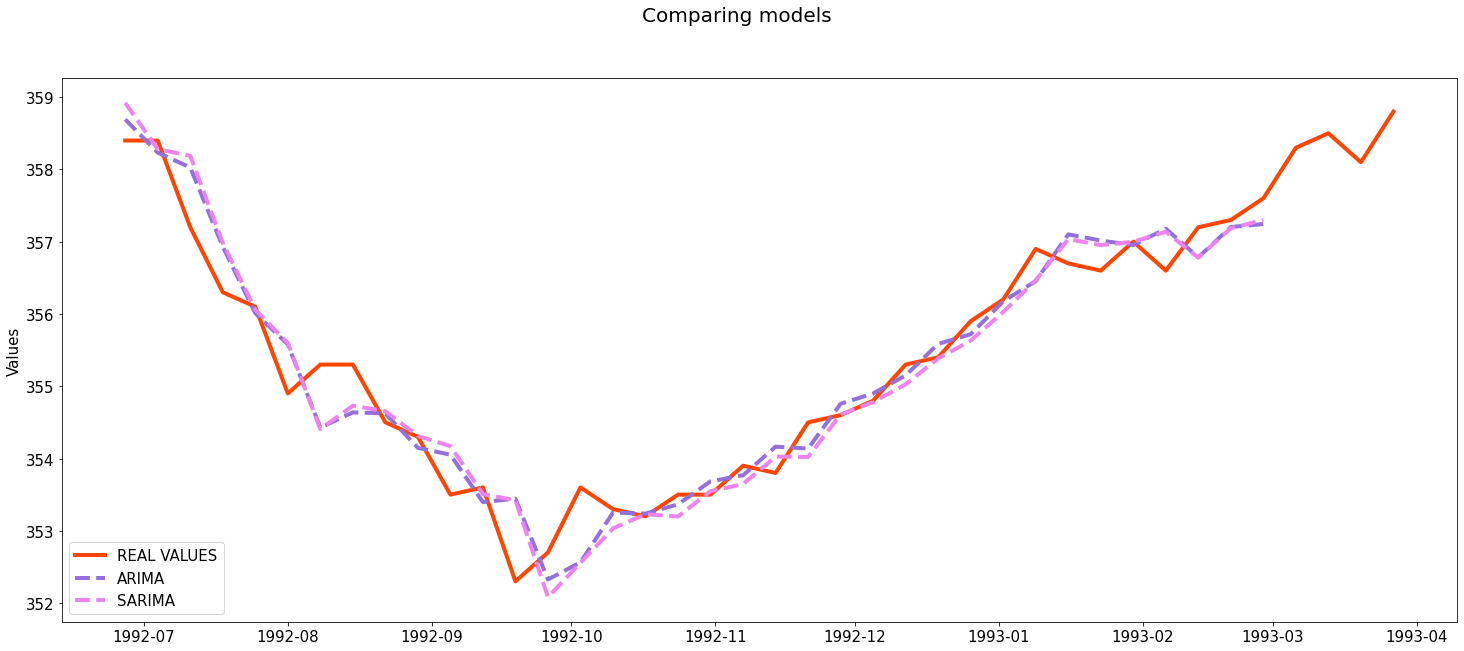

In [158]:
comparing_results(train_set[-40:], {'arima' : arima_predictions_n_i, 'sarima' : sarima_predictions_n_i})

##### Both ARIMA and SARIMA models achieved very similar results when predicting time series values. It is also worth noting that both models made almost identical errors during prediction, as can be seen in the graph above.

##### Task 5

##### In this library I was able to find the ARDL model

In [160]:
from statsmodels.tsa.ardl import ARDL

model = ARDL(train_set, 30)
fitted_model_ARDL = model.fit()

In [172]:
preds_ardl_1 = fitted_model_ARDL.predict(start=train_set.index[-400], end=test_set.index[6])

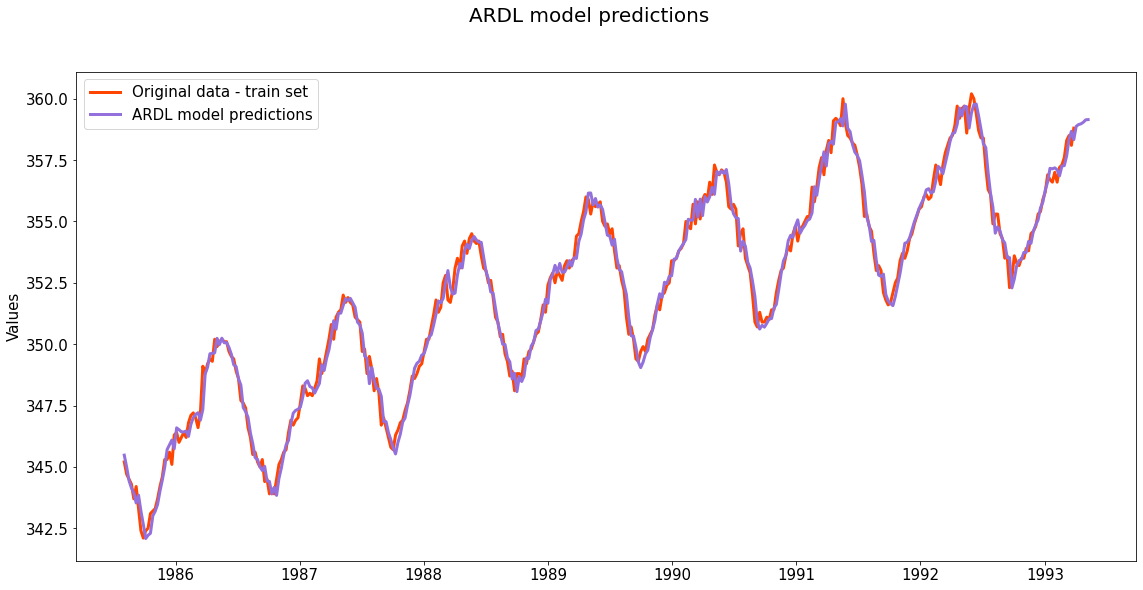

In [173]:
plotting_predictions(preds_ardl_1, train_set=train_set, test_set=test_set, pred_type='predictions', n_train_samples = 400, model_type = 'ARDL', y_lim = None)

In [178]:
preds_ardl_2 = fitted_model_ARDL.predict(start=train_set.index[-30], end=test_set.index[1])

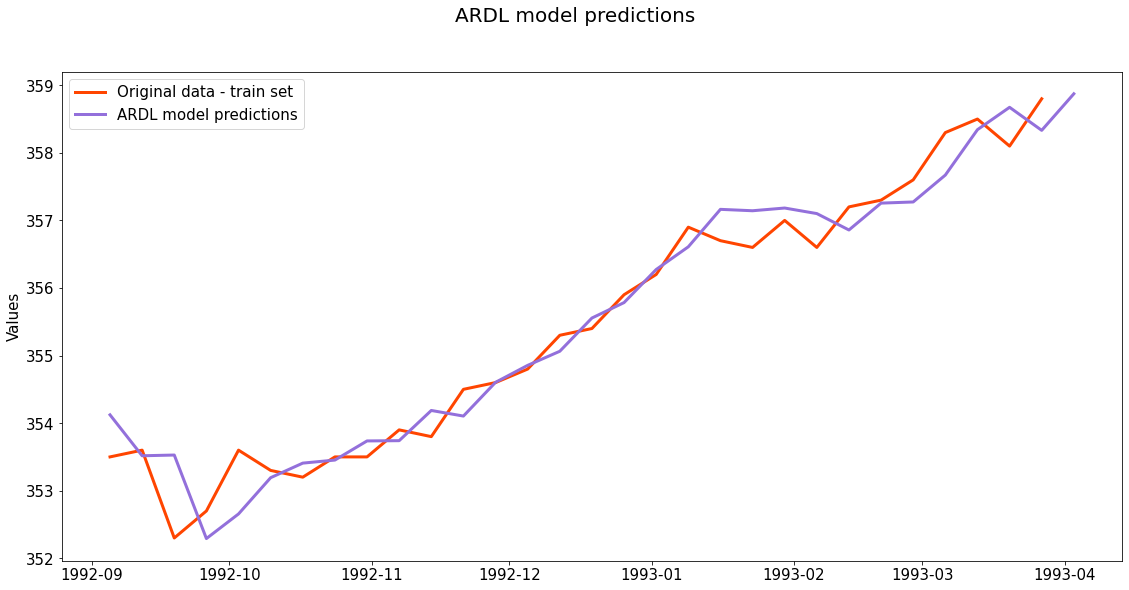

In [179]:
plotting_predictions(preds_ardl_2, train_set=train_set, test_set=test_set, pred_type='predictions', n_train_samples = 30, model_type = 'ARDL', y_lim = None)

##### The predictions for the ARDL model are, like those for the ARIMA and SAMIRA models, very close to the true values, it is only when looking at a certain time segment that some differences become apparent.

In [203]:
resids_ardl = train_set['co2'][-400:] - preds_ardl_1[:400]
t = train_set['co2'][-400:]

print(f'Mean Absolute Percent Error for ARDL model: {round(np.mean(abs(resids_ardl / t)), 4)}')

Mean Absolute Percent Error for ARDL model: 0.001


##### The mean absolute percentage error for the 400 predicted values was just 0.001, which is excellent for so many observations.
